# Control Variables

Important variables used throughout the code can be changed here.
- `segmentation_window_size`: every signal in a database is sliced into pieces of `segmentation_window_size` seconds to make the signals more comparable
- `tolerance_window_size`: to determine whether a QRS complex was determined correctly a tolerance window of ±`tolerance_window_size` milliseconds is used
- `print_detector_failure`: to decide whether a print should be shown if a detecor failes

In [97]:
segmentation_window_size = 30 # in seconds, default = 30
tolerance_window_size = 75 #150 # in milliseconds, default = 150
max_read_time_minutes = 120 # maximally read 120 minutes of the signal and process it, change to -1 to disable
print_detector_failure = 1 # print detector failure, 1 to print them, 0 to not print them, default = 0
time_all_in_Python = False # desides whether all detectors should be retimed in Python or if detectors may return their own runtime, True to rerun runtime estimation, default = False

import_SIN_from_wfdb = False

## Experiment - Real Databases

Important variables for the real databases experiment are declared and changed here.

In [98]:
evaluate_SIN_database = False # evaluate SIN database, True to evaluate, False to skip evaluation, default = False, evaluation takes long
evaluate_ARR_database = False # TO BE DONE evaluate ARR database, True to evaluate, False to skip evaluation, default = False, evaluation takes long
evaluate_HIGH_database = False # evaluate HIGH database, True to evaluate, False to skip evaluation, default = False, evaluation takes long
evaluate_LOW_database = False # evaluate LOW database, True to evaluate, False to skip evaluation, default = False, evaluation takes long
evaluate_TELE_database = False # evaluate TELE database, True to evaluate, False to skip evaluation, default = False, evaluation takes long
evaluate_SAFER_database = False # evaluate SAFER database, True to evaluate, False to skip evaluation, default = False, evaluation takes long

## Experiment - Synthetic Data

Important variables for the synthetic data experiment are declared and changed here.

In [99]:
generate_SYNTH_database = False # simulate SYNTH database, True to simulate, False to skip simulation, default = False, simulation takes long
evaluate_SYNTH_database = False # evaluate SYNTH database, True to evaluate, False to skip evaluation, default = False, evaluation takes long
use_SYNTH_database = False # whether or not to include SYNTH database in analysis


# General Setup

## Import Libraries & Start Engines

Install all important libraries with pip apart from `matlab.engine` which has to be installed from the MATLAB root folder. You can find more information on instlaling the `matlab.engine` [here](https://de.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)

In [100]:
# MATLAB library
import matlab.engine
# general math libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
#%matplotlib widget
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from scipy import stats
# other general libraries
import time
import pickle
import os
from os import listdir
from os.path import isfile, join
from itertools import cycle
import pandas
import seaborn as sns 
from statannot import add_stat_annotation
from tol_colors import tol_cmap, tol_cset
# ecg signal and detector libraries
import wfdb
from wfdb import processing
from ecgdetectors import Detectors
from detectors.visgraphdetector import VisGraphDetector
from vg_beat_detectors import FastNVG, FastWHVG

import neurokit2 as nk

Start the `matlab.engine` to be able to execute MATLAB commands or functions from within Python.

In [101]:
eng = matlab.engine.start_matlab()

## Other Variables

Create variables with current working directory.

In [102]:
current_working_directory = os.getcwd()
current_working_directory = '/Users/petercharlton/Documents/GitHub/ecg_detector_assessment/Algorithm_tester'
parent_directory = os.path.dirname(current_working_directory)

Set general graph settings.

In [103]:
cmap = np.append(matplotlib.colors.to_rgba_array(tol_cset('bright')).tolist()[0:-1], matplotlib.colors.to_rgba_array(tol_cset('light')).tolist(),axis=0).tolist()
flierprops = dict(marker='o', markersize=0.5)
saturation = 1
linewidth = 0.5
linecolor = '0'
capsize = 0.4
errorbar = ("pi", 50)
estimator = np.median

## Define Classes and Functions

`Detector` class to store all values necessary for a detector. This can later be added to a list of `detectors`.

In [104]:
class Detector():
    def __init__(self, name, short_name, algorithm, implementation = None) -> None:
        self.name = name
        self.algorithm = algorithm
        self.short_name = short_name
        self.implementation = implementation
    
    def predicted_qrs_compelx(self, signal, fs):
        return self.algorithm(signal, fs)

    def name(self):
        return self.name

    def short_name(self):
        return self.short_name
    
    def implementation(self):
        return self.implementation

An `Evaluation` gets a `RecordingSegment` or `Recording` described below and the functions `predicted_peaks`, `binary_classification`, and `score_calculation`. The function `calculate` returns the whole element including `predicted_peaks`, number of predicted peaks `pp`, true positives `tp`, false positives `fp`, false negatives `fn`, `sensitivity`, `positive_predictivity`, and the `f1_score`.

In [105]:
class Evaluation():
    def __init__(self, RecordingSegment, Detector, predict_peaks, binary_classification, score_calculation) -> None:
        self.RecordingSegment = RecordingSegment
        self.Detector = Detector
        self.predict_peaks = predict_peaks
        self.binary_classification = binary_classification
        self.score_calculation = score_calculation
        self.predicted_peaks = None # predicted peaks as indexes
        self.runtime = 0
        self.pp = self.tp = self.fp = self.fn = None # number of predicted peaks, true positives, false positives, false negatives respectively
        self.sensitivity = self.positive_predictivity = self.f1_score = None
        self.failed = None
    
    def calculate(self):
        self.predicted_peaks, self.runtime, self.failed = self.predict_peaks(self.RecordingSegment,self.Detector)
        self.pp, self.tp, self.fp, self.fn = self.binary_classification(self.RecordingSegment, self.predicted_peaks)
        self.sensitivity, self.positive_predictivity, self.f1_score = self.score_calculation(self.tp, self.fp, self.fn)
        return self

`Database` class to store all values necessary for a databse. This can later be added to a list of `databases`.

In [106]:
class Database():
    def __init__(self, Name, Users, Fs) -> None:
        self.Name = Name
        self.Users = Users
        self.Fs = Fs

    def Name(self):
        return self.Name

    def Users(self):
        return self.Users

    def Fs(self):
        return self.Fs

Each `Database` stores a list of `Users`. This `User` class stores important information about a user and a list to `Recordings` this user took. `User` can here also be used if a database stores arrythmia and sinus rythm signals.

In [107]:
class User():
    def __init__(self, UserName,Recordings) -> None:
        self.UserName = UserName
        self.Recordings = Recordings

    def UserName(self):
        return self.UserName

    def Recordings(self):
        return self.Recordings

Each `User` stores a list of `Recordings`. This `Recording` class stores important information about a recording and a list to `RecordingSegments` created from the signal in `Recording`. `Recording` stores the whole unsplit signal and list of actual QRS complexes. 

In [108]:
class Recording():
    def __init__(self, RecordingName, RecordingSegments, WholeSignal, WholeActual_Qrs_Complex, Fs, AdditionalInfo = None, Gender = None, Age = -1, Quality = None, AF_SR = None, Mask = None) -> None:
        self.RecordingName = RecordingName
        self.RecordingSegments = RecordingSegments
        self.WholeSignal = WholeSignal
        self.WholeActual_Qrs_Complex = WholeActual_Qrs_Complex
        self.Fs = Fs
        self.Evaluations = []
        self.AdditionalInfo = AdditionalInfo
        self.Gender = Gender
        self.Age = Age
        self.Quality = Quality
        self.AF_SR = AF_SR
        self.Mask = Mask

    def RecordingName(self):
        return self.RecordingName
    
    def RecordingSegments(self):
        return self.RecordingSegments

    def WholeSignal(self):
        return self.WholeSignal
    
    def WholeActual_Qrs_Complex(self):
        return self.WholeActual_Qrs_Complex

    def Fs(self):
        return self.Fs

    def Mask(self):
        return self.Mask

    def Gender(self):
        return self.Gender

    def Age(self):
        return self.Age

    def Evaluation(self, detectors, predict_peaks, binary_classification, score_calculation):
        self.Evaluations = []
        for detector in detectors:
            self.Evaluations.append(Evaluation(self,detector,predict_peaks, binary_classification, score_calculation).calculate())
        return self.Evaluations
    
    def addAdditionalInfo(self, AdditionalInfo):
        self.AdditionalInfo = AdditionalInfo

Each `Recording` stores a list of `RecordingSegments`. The `RecordingSegment` class stores important information about a segment of a recording. The function `Evaluation` which takes a list of `detectors` and three functions as an input returns a list of `Evaluation` objects, one for each detector.

In [109]:
class RecordingSegment():
    def __init__(self, Signal, Actual_Qrs_Complex, Fs, AdditionalInfo = None, Mask = None) -> None:
        self.Signal = Signal
        self.Actual_Qrs_Complex = Actual_Qrs_Complex
        self.Fs = Fs
        self.Evaluations = []
        self.AdditionalInfo = AdditionalInfo
        self.Mask = Mask

    def Signal(self):
        return self.Signal

    def Actual_Qrs_Complex(self):
        return self.Actual_Qrs_Complex

    def Fs(self):
        return self.Fs

    def Mask(self):
        return self.Mask

    def Evaluation(self, detectors, predict_peaks, binary_classification, score_calculation):
        self.Evaluations = []
        for detector in detectors:
            self.Evaluations.append(Evaluation(self,detector,predict_peaks, binary_classification, score_calculation).calculate())
        return self.Evaluations

    def addAdditionalInfo(self, AdditionalInfo):
        self.AdditionalInfo = AdditionalInfo

This is a function to split signals in smaller parts including the respecitve qrs complexes. `split_signal` returns an array of arrays where the inner arrays store the signals and the qrs complexes and the outer array stores the inner arrays.

In [110]:
def split_signal(signal, fs, actual_qrs_complexes, mask=None):
    signal = np.array(signal)
    actual_qrs_complexes = np.array(actual_qrs_complexes)
    if mask is not None:
        mask = np.array(mask)
    split = [[] for i in range(((len(signal)//(fs*segmentation_window_size)*2)-1))]

    for split_signal_counter in range((len(signal)//(fs*segmentation_window_size)*2)-1):
        min_index = split_signal_counter*(fs*segmentation_window_size//2)
        max_index = split_signal_counter*(fs*segmentation_window_size//2)+fs*segmentation_window_size-1

        split[split_signal_counter].append(signal[min_index:max_index])

        min_counter = 0
        max_counter = 0

        for qrs_complex_counter in range(len(actual_qrs_complexes)):
            if actual_qrs_complexes[qrs_complex_counter] < min_index:
                min_counter += 1
            if actual_qrs_complexes[qrs_complex_counter] < max_index:
                max_counter += 1
        split[split_signal_counter].append(actual_qrs_complexes[min_counter:max_counter]-min_index)
        if mask is not None:
            split[split_signal_counter].append(mask[min_index:max_index])
        else:
            split[split_signal_counter].append(None)

    return split


## Create Database Objects

### SIN - MIT-BIH Normal Sinus Rhythm Database
Create a `Database` object for `mit_bih_normal_sinus_rhythm_database` including all sub objects necessary to initialize it. The database can be found [here](https://physionet.org/content/nsrdb/1.0.0/).

In [111]:
if evaluate_SIN_database and import_SIN_from_wfdb:
    path = join(current_working_directory,'databases/SIN')
    files = np.array(pandas.read_csv(join(path, "RECORDS"),header=None)[0])

    fs = wfdb.rdrecord(join(path,str(files[0])), channels=[0]).fs

    users = []

    for file in files:
        recordings = []
        recordingsegments = []
        if max_read_time_minutes == -1:
            reading = wfdb.rdrecord(join(path,str(file)), channels=[0])
        else:
            reading = wfdb.rdrecord(join(path,str(file)), channels=[0],sampfrom=0, sampto=max_read_time_minutes*60*fs)
        signal = np.array(reading.p_signal[:,0]).astype(float)
        actual_qrs_complexes = np.array(wfdb.rdann(join(path,str(file)),'atr',sampfrom=0, sampto=max_read_time_minutes*60*fs).sample[1:]).astype(int)
        comments = np.array(reading.comments)
        age = int(comments[0].split()[0])
        gender = comments[0].split()[1]

        splits = split_signal(signal=signal,fs=fs, actual_qrs_complexes=actual_qrs_complexes)
        
        for split in splits:
            recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=fs))
        recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, Gender=gender, Age=age, AdditionalInfo=comments))
        users.append(User(UserName=str(file),Recordings = recordings))

    mit_bih_normal_sinus_rhythm_database = Database(
        Name="MIT-BIH Normal Sinus Rhythm Database",
        Users=users,
        Fs=fs)

In [112]:
if evaluate_SIN_database and import_SIN_from_wfdb:
    if not os.path.isdir('pickle'):
        print('Creating ''pickle'' directory as it doesn''t exist')
        os.mkdir('pickle')

    filename = 'pickle/mit_bih_normal_sinus_rhythm_database.pkl'
    file = open(filename, 'wb')
    pickle.dump(mit_bih_normal_sinus_rhythm_database, file)
    file.close()

In [113]:
if evaluate_SIN_database and not import_SIN_from_wfdb:
    filename = 'pickle/mit_bih_normal_sinus_rhythm_database.pkl'
    file = open(filename, 'rb')
    mit_bih_normal_sinus_rhythm_database = pickle.load(file)
    file.close()

### ARR - MIT-BIH Arrhythmia Database
Create a `Database` object for `mit_bih_arrhythmia_database` including all sub objects necessary to initialize it. The database can be found [here](https://www.physionet.org/content/mitdb/1.0.0/).

In [114]:
if evaluate_ARR_database:
    path = join(current_working_directory,'databases/ARR')
    files = np.array(pandas.read_csv(join(path, "RECORDS"),header=None)[0])

    fs = wfdb.rdrecord(join(path,str(files[0])), channels=[0]).fs

    users = []

    for file in files:
        recordings = []
        recordingsegments = []
        signal = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).p_signal[:,0]).astype(float)
        actual_qrs_complexes = np.array(wfdb.rdann(join(path,str(file)),'atr').sample[1:]).astype(int)
        comments = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).comments)
        age = int(comments[0].split()[0])
        gender = comments[0].split()[1]

        splits = split_signal(signal=signal,fs=fs, actual_qrs_complexes=actual_qrs_complexes)
        
        for split in splits:
            recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=fs))
        recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, Gender=gender, Age=age, AdditionalInfo=comments))
        users.append(User(UserName=str(file),Recordings = recordings))

    mit_bih_arrhythmia_database = Database(
        Name="MIT-BIH Arrhythmia Database",
        Users=users,
        Fs=fs)

### HIGH - High Quality Database
[Training](https://physionet.org/content/challenge-2014/1.0.0/set-p/#files-panel) part of the 2014 Physionet/CINC Challange data.

In [115]:
if evaluate_HIGH_database:
    path = join(current_working_directory,'databases/HIGH')
    files = np.array(pandas.read_csv(join(path, "RECORDS"),header=None)[0])

    fs = wfdb.rdrecord(join(path,str(files[0])), channels=[0]).fs

    users = []

    for file in files:
        recordings = []
        recordingsegments = []
        signal = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).p_signal[:,0]).astype(float)
        actual_qrs_complexes = np.array(wfdb.rdann(join(path,str(file)),'atr').sample[1:]).astype(int)
        comments = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).comments)

        splits = split_signal(signal=signal,fs=fs, actual_qrs_complexes=actual_qrs_complexes)
        
        for split in splits:
            recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=fs))
        recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, AdditionalInfo=comments))
        users.append(User(UserName=str(file),Recordings = recordings))

    high_quality_database = Database(
        Name="High Quality Database",
        Users=users,
        Fs=fs)

### LOW - Low Quality Database
[Augmented Training](https://physionet.org/content/challenge-2014/1.0.0/set-p2/#files-panel) part of the 2014 Physionet/CINC Challange data.

In [116]:
if evaluate_LOW_database:
    path = join(current_working_directory,'databases/LOW')
    files = np.array(pandas.read_csv(join(path, "RECORDS"),header=None)[0])

    fs = wfdb.rdrecord(join(path,str(files[0])), channels=[0]).fs

    users = []

    for file in files:
        recordings = []
        recordingsegments = []
        signal = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).p_signal[:,0]).astype(float)
        actual_qrs_complexes = np.array(wfdb.rdann(join(path,str(file)),'atr').sample[1:]).astype(int)
        comments = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).comments)

        splits = split_signal(signal=signal,fs=fs, actual_qrs_complexes=actual_qrs_complexes)
        
        for split in splits:
            recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=fs))
        recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, AdditionalInfo=comments))
        users.append(User(UserName=str(file),Recordings = recordings))

    low_quality_database = Database(
        Name="Low Quality Database",
        Users=users,
        Fs=fs)

### TELE - Telehealth Database
Create a `Database` object for `telehealth_environment_database` including all sub objects necessary to initialize it. The database can be found [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/QTG0EP).

In [117]:
if evaluate_TELE_database:
    path = join(current_working_directory,'databases/TELE')
    files = [f for f in listdir(path) if isfile(join(path, f))]

    fs = 500
    users = []
    recordings = []
    for file in files:
        if file == 'LICENSE':
            continue
        recordingsegments = []
        data = pandas.read_csv(join(path, file),sep=",",header=None)
        signal = np.array(data[0]).astype(float)
        qrs_complex_indices = np.array(data[1]).astype(int)
        mask = np.array(data[2]).astype(int)
        actual_qrs_complexes = []
        
        for indexcounter in range(len(qrs_complex_indices)):
            if qrs_complex_indices[indexcounter]:
                actual_qrs_complexes.append(indexcounter)
        
        splits = split_signal(signal=signal,fs=fs, actual_qrs_complexes=np.array(actual_qrs_complexes).astype(int), mask=mask)
        
        for split in splits:
            recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=fs, Mask=split[2]))
        if len(signal) >= segmentation_window_size*fs:
            signal = signal[0:segmentation_window_size*fs]
            actual_qrs_complexes = np.array([qrs for qrs in actual_qrs_complexes if qrs < (segmentation_window_size*fs-1)])
            mask = mask[0:segmentation_window_size*fs]
        recordings.append(Recording(RecordingName=str(file),RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, Mask=mask))
    users.append(User(UserName="default",Recordings = recordings))   
            
    telehealth_environment_database = Database(
        Name="Telehealth Database",
        Users=users,
        Fs=fs)

### SAFER - SAFER Trial Database
Create a `Database` object for `safer_trial_database` including all sub objects necessary to initialize it. The database is a selection of the [SAFER Trial](https://www.safer.phpc.cam.ac.uk/) dataset.

In [118]:
if evaluate_SAFER_database:
    path = join(current_working_directory,'databases/SAFER')
    files = [f[0:-4] for f in listdir(path) if (isfile(join(path, f)) and f.endswith('.atr'))]

    fs = wfdb.rdrecord(join(path,str(files[0])), channels=[0]).fs

    users = []

    data = pandas.read_csv(join(path, 'rec_data_anon_3.csv'),sep=",")

    for file in files:
        
        measID = int(file[len(file)-6:])
        subject = data[data['measID'] == measID]

        gender = None
        if int(subject['gender']) == 1 : gender = 'F'
        elif int(subject['gender']) == 2 : gender = 'M'

        quality = None
        if int(subject['tag_orig_Poor_Quality']) == 0 : quality = 'HIGH'
        elif int(subject['tag_orig_Poor_Quality']) == 1 : quality = 'LOW'
        
        af_sr = None
        if int(subject['presAF']) == 0 : af_sr = 'nonAF'
        elif int(subject['presAF']) == 1 : af_sr = 'AF'

        age = int(subject['age'])

        ptID = int(subject['ptID'])

        recordings = []
        recordingsegments = []
        signal = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).p_signal[:,0]).astype(float)
        actual_qrs_complexes = np.array(wfdb.rdann(join(path,str(file)),'atr').sample[1:]).astype(int)
        comments = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).comments)

        splits = split_signal(signal=signal,fs=fs, actual_qrs_complexes=actual_qrs_complexes)
        
        for split in splits:
            recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=fs))

        if len(signal) >= segmentation_window_size*fs:
            signal = signal[0:segmentation_window_size*fs]
            actual_qrs_complexes = np.array([qrs for qrs in actual_qrs_complexes if qrs < (segmentation_window_size*fs-1)])
        
        #recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, AdditionalInfo=comments, Gender=gender, Quality = quality, AF_SR = af_sr, Age = age))
        recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, AdditionalInfo=ptID, Gender=gender, Quality = quality, AF_SR = af_sr, Age = age))
        users.append(User(UserName=str(file),Recordings = recordings))

    safer_trial_database = Database(
        Name="SAFER Trial Database",
        Users=users,
        Fs=fs)

### TEST - Test Database
Create a `Database` object for `wfdb_test_database` including all sub objects necessary to initialize it. This is just a test signal.

In [119]:
fs = wfdb.rdrecord('databases/TEST/100', sampfrom=0, sampto=30000, channels=[0]).fs
signal = np.array(wfdb.rdrecord('databases/TEST/100', sampfrom=0, sampto=30000, channels=[0]).p_signal[:,0])
actual_qrs_complexes = np.array(wfdb.rdann('databases/TEST/100','atr', sampfrom=0, sampto=30000).sample[1:]).astype(int)

splits = split_signal(signal=signal, fs=fs, actual_qrs_complexes=actual_qrs_complexes)

recordingsegments = []
for split in splits:
    recordingsegments.append(RecordingSegment(Signal=split[0],Actual_Qrs_Complex=split[1],Fs=fs))
recordings = [Recording("default",RecordingSegments=recordingsegments, WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs)]
users = [User(UserName="default",Recordings=recordings)]

wfdb_test_database = Database(
    Name="WFDB Test Database",
    Users=users,
    Fs=fs)

## Create Detector Objects

Create `Detector` objects for detectors from different locations in the standaradized format.

Create `gqrs_detector` object. This detector stems from the wfdb toolbox. More information can be found online.

In [120]:
def run_gqrs_detector(signal, fs):
    predicted_peaks = processing.qrs.gqrs_detect(signal, fs)
    runtime = -1
    return predicted_peaks, runtime

gqrs_detector = Detector(name="GQRS", short_name="gqrs", algorithm=run_gqrs_detector, implementation='Python')

Create `jqrs_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [121]:
path = eng.genpath(join(current_working_directory,'detectors\jqrs'))
eng.addpath(path, nargout=0)

def run_jqrs_detector(signal, fs):
    threshold = 0.6 # energy threshold of the detector in au, default = 0.6
    ref_period = 0.250 # refractory period in sec between two R-peaks in ms, default = 0.250
    newsignal = [[i] for i in signal]
    return_val = eng.qrs_detect2(matlab.double(newsignal), threshold, ref_period, matlab.double(fs))
    predicted_peaks =  np.array(return_val['qrs_pos'])[0].astype(int)
    runtime = return_val['runtime'] #np.array(return_val['runtime'])[0].astype(float)
    return predicted_peaks, runtime

jqrs_detector = Detector(name="JQRS", short_name="jqrs", algorithm=run_jqrs_detector, implementation='MATLAB')

Create `visgraph_detector` object. For this detector a Python implementation is used. More information can be found in the respective file.

In [122]:
def run_visgraph_detector(signal, fs):
    beta = 0.55 # beta, default = 0.55
    gamma = 0.5 # gamm, default = 0.5
    lowcut = 4 # lowcut, default = 4
    R_peaks, weights, weighted_signal = VisGraphDetector(fs).visgraphdetect(signal, beta=beta, gamma=gamma, lowcut=lowcut, M = 2*fs)
    predicted_peaks = R_peaks
    runtime = -1
    return predicted_peaks, runtime

visgraph_detector = Detector(name="VisGraphDetector", short_name="visgraph", algorithm=run_visgraph_detector, implementation='Python')

Create `fastnvg_detector` object. For this detector a Python implementation is used. More information can be found in the respective file.

In [123]:
def run_fastnvg_detector(signal, fs):
    detect = FastNVG(sampling_frequency=fs)
    R_peaks = detect.find_peaks(signal)
    predicted_peaks = R_peaks
    runtime = -1
    return predicted_peaks, runtime

fastnvg_detector = Detector(name="FastNVG", short_name="fastnvg", algorithm=run_fastnvg_detector, implementation='Python')

Create `fastwhvg_detector` object. For this detector a Python implementation is used. More information can be found in the respective file.

In [124]:
def run_fastwhvg_detector(signal, fs):
    detect = FastWHVG(sampling_frequency=fs)
    R_peaks = detect.find_peaks(signal)
    predicted_peaks = R_peaks
    runtime = -1
    return predicted_peaks, runtime

fastwhvg_detector = Detector(name="FastWhVG", short_name="fastwhvg", algorithm=run_fastwhvg_detector, implementation='Python')

Create `rpeakdetect_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [125]:
path = eng.genpath(join(current_working_directory,'detectors'))
eng.addpath(path, nargout=0)

def run_rpeakdetect_detector(signal, fs):
    threshhold = 0.2 # default = 0.2
    testmode = 0 # default = 0
    newsignal = [[i] for i in signal]
    return_val = eng.rpeakdetect(matlab.double(newsignal), matlab.double(fs),threshhold,testmode)
    predicted_peaks = np.array(return_val['R_index'])[0].astype(int)
    runtime = return_val['runtime'] #np.array(return_val['runtime'])[0].astype(float)
    return predicted_peaks, runtime

rpeakdetect_detector = Detector(name="rpeakdetect", short_name="rpeak", algorithm=run_rpeakdetect_detector, implementation='MATLAB')

Create `r_deco_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [126]:
path = eng.genpath(join(current_working_directory,'detectors/r_deco'))
eng.addpath(path, nargout=0)

def run_r_deco_detector(signal, fs):
    envelope_size = 300.0 # envelope size in ms, default = 300.0
    average_heart_rate = 100.0 # average heart rate in bpm, default = 100.0
    post_processing = 1.0 # post processing where 1.0 means yes, default = 1.0
    ectopic_removal = 0.0 # ectopic removal where 1.0 means yes, default = 0.0
    inverted_signal = 0.0 # inverted signal where 1.0 means yes, default = 0.0
    parameters_check = 0.0 # parameters check in UI where 1.0 means yes, default = 0.0
    newsignal = [[i] for i in signal]
    return_val = eng.peak_detection([envelope_size,average_heart_rate,post_processing,ectopic_removal,inverted_signal],matlab.double(newsignal), matlab.double(fs),parameters_check)
    predicted_peaks = np.array(return_val['R_peak'])[0][0].astype(int)
    runtime = return_val['runtime'] #np.array(return_val['runtime'])[0][0].astype(float)
    return predicted_peaks, runtime

r_deco_detector = Detector(name="r_deco", short_name="rdeco", algorithm=run_r_deco_detector, implementation='MATLAB')

Create `unsw_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [127]:
path = eng.genpath(join(current_working_directory,'detectors/unsw'))
eng.addpath(path, nargout=0)

def run_unsw_detector(signal, fs):
    mask = [] # mask could be implemented later if wanted
    plotting = False # 1.0 for ploting intermediate signals, 0.0 for no plotting, default = 0.0
    newsignal = [[i] for i in signal]
    return_val = eng.UNSW_QRSDetector(matlab.double(newsignal), matlab.double(fs),matlab.double(mask),bool(plotting))
    predicted_peaks = np.array(return_val['qrs'])[0].astype(int)
    runtime = return_val['runtime'] #np.array(return_val['runtime'])[0].astype(float)
    return predicted_peaks, runtime

unsw_detector = Detector(name="UNSW_QRSDetector", short_name="unsw", algorithm=run_unsw_detector, implementation='MATLAB')

Create functions to get the detectors from the `ecgdetectors` package into the right standard format. Additionally they are safed into their own objects. More information about the package can be found online.

In [128]:
def run_two_average_detector(signal, fs):
    return Detectors(fs).two_average_detector(unfiltered_ecg=signal), -1

two_average_detector = Detector(name="Elgendi et al (Two average)", short_name="two_avg", algorithm=run_two_average_detector, implementation='Python')

def run_matched_filter_detector(signal, fs):
    return Detectors(fs).matched_filter_detector(unfiltered_ecg=signal), -1

matched_filter_detector = Detector(name="Matched filter", short_name="match_fil", algorithm=run_matched_filter_detector, implementation='Python')

def run_swt_detector(signal, fs):
    return Detectors(fs).swt_detector(unfiltered_ecg=signal), -1

swt_detector = Detector(name="Kalidas & Tamil (Wavelet transform)", short_name="swt", algorithm=run_swt_detector, implementation='Python')

def run_engzee_detector(signal, fs):
    return Detectors(fs).engzee_detector(unfiltered_ecg=signal), -1

engzee_detector = Detector(name="Engzee", short_name="engz", algorithm=run_engzee_detector, implementation='Python')

def run_christov_detector(signal, fs):
    return Detectors(fs).christov_detector(unfiltered_ecg=signal), -1

christov_detector = Detector(name="Christov", short_name="christ", algorithm=run_christov_detector, implementation='Python')

def run_hamilton_detector(signal, fs):
    return Detectors(fs).hamilton_detector(unfiltered_ecg=signal), -1

hamilton_detector = Detector(name="Hamilton", short_name="hamilt", algorithm=run_hamilton_detector, implementation='Python')

def run_pan_tompkins_detector(signal, fs):
    return Detectors(fs).pan_tompkins_detector(unfiltered_ecg=signal), -1

pan_tompkins_detector = Detector(name="Pan Tompkins", short_name="pan_tomp", algorithm=run_pan_tompkins_detector, implementation='Python')

def run_wqrs_detector(signal, fs):
    return Detectors(fs).wqrs_detector(unfiltered_ecg=signal), -1

wqrs_detector = Detector(name="WQRS", short_name="wqrs", algorithm=run_wqrs_detector, implementation='Python')

Create functions to get the detectors from the `neurokit2` package into the right standard format. Additionally they are safed into their own objects. More information about the package can be found online.

In [129]:
def run_neurokit(signal, fs):
    # neurokit (default)
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="neurokit")
    _, neurokit = nk.ecg_peaks(cleaned, sampling_rate=fs, method="neurokit")
    return neurokit["ECG_R_Peaks"], -1

neurokit_detector = Detector(name="neurokit", short_name="nk", algorithm=run_neurokit, implementation='Python')

def run_pantompkins1985(signal, fs):
    # pantompkins1985
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="pantompkins1985")
    _, pantompkins1985 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="pantompkins1985")
    return pantompkins1985["ECG_R_Peaks"], -1

pantompkins1985_detector = Detector(name="pantompkins1985", short_name="pan_tomp_nk", algorithm=run_pantompkins1985, implementation='Python')

def run_nabian2018(signal, fs):
    # nabian2018
    _, nabian2018 = nk.ecg_peaks(signal, sampling_rate=fs, method="nabian2018")
    return nabian2018["ECG_R_Peaks"], -1

nabian2018_detector = Detector(name="nabian2018", short_name="nab_nk", algorithm=run_nabian2018, implementation='Python')

def run_hamilton2002(signal, fs):
    # hamilton2002
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="hamilton2002")
    _, hamilton2002 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="hamilton2002")
    return hamilton2002["ECG_R_Peaks"], -1

hamilton2002_detector = Detector(name="hamilton2002", short_name="ham_nk", algorithm=run_hamilton2002, implementation='Python')

def run_martinez2003(signal, fs):
    # martinez2003
    _, martinez2003 = nk.ecg_peaks(signal, sampling_rate=fs, method="martinez2003")
    return martinez2003["ECG_R_Peaks"], -1

martinez2003_detector = Detector(name="martinez2003", short_name="mart_nk", algorithm=run_martinez2003, implementation='Python')

def run_zong2003(signal, fs):
    # zong2003
    _, zong2003 = nk.ecg_peaks(signal, sampling_rate=fs, method="zong2003")
    return zong2003["ECG_R_Peaks"], -1

zong2003_detector = Detector(name="zong2003", short_name="zong_nk", algorithm=run_zong2003, implementation='Python')

def run_christov2004(signal, fs):
    # christov2004
    _, christov2004 = nk.ecg_peaks(signal, sampling_rate=fs, method="christov2004")
    return christov2004["ECG_R_Peaks"], -1

christov2004_detector = Detector(name="christov2004", short_name="chris_nk", algorithm=run_christov2004, implementation='Python')

def run_gamboa2008(signal, fs):
    # gamboa2008
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="gamboa2008")
    _, gamboa2008 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="gamboa2008")
    return gamboa2008["ECG_R_Peaks"], -1

gamboa2008_detector = Detector(name="gamboa2008", short_name="gamb_nk", algorithm=run_gamboa2008, implementation='Python')

def run_elgendi2010(signal, fs):
    # elgendi2010
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="elgendi2010")
    _, elgendi2010 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="elgendi2010")
    return elgendi2010["ECG_R_Peaks"], -1

elgendi2010_detector = Detector(name="elgendi2010", short_name="elg_nk", algorithm=run_elgendi2010, implementation='Python')

def run_engzeemod2012(signal, fs):
    # engzeemod2012
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="engzeemod2012")
    _, engzeemod2012 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="engzeemod2012")
    return engzeemod2012["ECG_R_Peaks"], -1

engzeemod2012_detector = Detector(name="engzeemod2012", short_name="engz_nk", algorithm=run_engzeemod2012, implementation='Python')

def run_kalidas2017(signal, fs):
    # kalidas2017
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="kalidas2017")
    _, kalidas2017 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="kalidas2017")
    return kalidas2017["ECG_R_Peaks"], -1

kalidas2017_detector = Detector(name="kalidas2017", short_name="kali_nk", algorithm=run_kalidas2017, implementation='Python')

def run_rodrigues2021(signal, fs):
    # rodrigues2021
    _, rodrigues2021 = nk.ecg_peaks(signal, sampling_rate=fs, method="rodrigues2021")
    return rodrigues2021["ECG_R_Peaks"], -1

rodrigues2021_detector = Detector(name="rodrigues2021", short_name="rodr_nk", algorithm=run_rodrigues2021, implementation='Python')

## Calculation functions

### Predict Peaks Function

The function `predict_peaks` predicts peaks in a signal. It needs a segment which can either be a `RecordingSegment` or a `Recording` and a `Detector` as an input. The output is a vector of predicted peaks.

In [130]:
def predict_peaks(segment, detector_input):
    failed = False

    if isinstance(segment, RecordingSegment):
        signal = segment.Signal
        fs = segment.Fs

    elif isinstance(segment, Recording):
        signal = segment.WholeSignal
        fs = segment.Fs

    else:
        raise Exception('You have to input either a RecordingSegment or a Recording as the segment.')
        
    
    if detector_input.short_name == "match_fil" and (fs != 250 and fs != 360):
        if print_detector_failure:
            failed = True
            print(detector_input.short_name, "could not run because the sample rate is wrong and was skipped")
        return [], 0, failed

    #predicted_peaks = detector.predicted_qrs_compelx(signal=signal, fs=fs)
    start = time.time()
    try:
        predicted_peaks, runtime = detector_input.predicted_qrs_compelx(signal=signal, fs=fs)
    except IndexError:
        if print_detector_failure:
            failed = True
            print(detector_input.short_name, "failed due to an index error and was skipped")
        return [], 0, failed
    except matlab.engine.MatlabExecutionError:
        if print_detector_failure:
            failed = True
            print(detector_input.short_name, "failed due to a MatlabExecutionError, most likely the signal quality was to bad")
        return [], 0, failed
    except OverflowError:
        if print_detector_failure:
            failed = True
            print(detector_input.short_name, "failed due to a Overflow Error, most likely the signal quality was to bad")
        return [], 0, failed
    if runtime == -1 or time_all_in_Python:
        runtime = time.time() - start
    if detector_input.implementation == 'MATLAB':
        pass

    return predicted_peaks, runtime, failed

### Binary Classification Function

The function `binary_classification` classifies whether the predicted peaks are true-positive, false-positive, and false-negative. It needs a segment which can either be a `RecordingSegment` or a `Recording` and a vector of `predicted_peaks` as an input. The output is the number of predicted peaks `pp`, the number of true-positive peaks `tp`, the number of false-positive peaks `fp`, and the number of false-negative peaks `fn`.

In [131]:
def binary_classification(segment, predicted_peaks):

    if isinstance(segment, RecordingSegment):
        actual_peaks = segment.Actual_Qrs_Complex

    elif isinstance(segment, Recording):
        actual_peaks = segment.WholeActual_Qrs_Complex

    else:
        raise Exception('You have to input either a RecordingSegment or a Recording as the segment.')

    mask = segment.Mask

    pp = 0
    tp = 0
    fp = 0
    fn = 0
    
    actual_peaks_iter = actual_peaks

    for predicted_peak in predicted_peaks:
        if mask is not None:
            if mask[predicted_peak]:
                continue
        pp+=1
        tpdetect = 1
        for i in range(len(actual_peaks_iter)):
            if predicted_peak >= (actual_peaks_iter[i] - tolerance_window_size) and predicted_peak <= (actual_peaks_iter[i] + tolerance_window_size):
                tp+=1
                tpdetect = 0
                actual_peaks_iter = np.delete(actual_peaks_iter, i)
                break
        if tpdetect:
            fp+=1

    for actualpeak in actual_peaks_iter:
        fn+=1

    return pp, tp, fp, fn

### Score Calculation Function

Function `score_calculation` to calculate the sensitivity, positive predictivity, and F1-score.

In [132]:
def score_calculation(tp, fp, fn):
    try:
        sensitivity = tp / (tp+fn)
    except ZeroDivisionError:
        sensitivity = 0
    try:
        positive_predictivity = tp / (tp+fp)
    except ZeroDivisionError:
        positive_predictivity = 0
    try:    
        f1_score = tp / (tp+.5*(fp+fn))
    except ZeroDivisionError:
        f1_score = 0
    return sensitivity, positive_predictivity, f1_score

## Add Databases and Detectors

Create arrays to safe the `detectors` and `databases`.

In [133]:
databases = []
detectors = []

Add data from different databases to `databases`. By commenting or uncommenting a database here, you can decide whether it should be used in the code.

In [134]:
#databases.append(synth_database)
databases.append(wfdb_test_database)
#databases.append(telehealth_environment_database)
#databases.append(mit_bih_arrhythmia_database)

Add detectors to the `detectors`. By commenting or uncommenting a detector here, you can decide whether it should be used in the code.

In [135]:

detectors.append(gqrs_detector)
detectors.append(jqrs_detector)
# detectors.append(visgraph_detector) # takes a lot of time, not used because it takes long and does not give good results
detectors.append(rpeakdetect_detector)
detectors.append(r_deco_detector)
detectors.append(unsw_detector)
# detectors.append(matched_filter_detector) # in ecg-detectors package but not used in neurkit, might be to useless because of frequencies, not used because of frequency issue

detectors.append(wqrs_detector) # differnt implementation of neurokit zong implementation, used because it works, rather slow though
# detectors.append(zong2003_detector) # neurokit detector, different from wqrs, does not work, not used because implementation does not work

# detectors.append(swt_detector) # same es neurokit kalidas implementation but a bit slower even though both refer to the ecg-detectors package, not used because neurokit implementation is faster
detectors.append(kalidas2017_detector) # neurokit detector, same as swt, changed implementation slightly from ecg-detectors package

detectors.append(two_average_detector) #  es neurokit elgendi implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(elgendi2010_detector) # neurokit detector, same as two_average, not used because base implementation is faster

detectors.append(engzee_detector) # same es neurokit engzee implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(engzeemod2012_detector) # neurokit detector, same as engzee, not used because base implementation is faster

detectors.append(christov_detector) # same es neurokit christov implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(christov2004_detector) # neurokit detector, not used because base implementation is faster

detectors.append(hamilton_detector) # same es neurokit hamilton implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(hamilton2002_detector) # neurokit detector, same as hamilton, not used because base implementation is faster 

# detectors.append(pan_tompkins_detector) # same as neurokit pan_tompkins implementation but slower even though both refer to the ecg-detectors package, not used because neurokit implementation is faster
detectors.append(pantompkins1985_detector) # neurokit detector, same as pan_tompkins

detectors.append(neurokit_detector) # neurokit detector, new
detectors.append(nabian2018_detector) # neurokit detector, new
detectors.append(martinez2003_detector) # neurokit detector, new
detectors.append(gamboa2008_detector) # neurokit detector, new
# detectors.append(rodrigues2021_detector) # neurokit detector, fails often and does not give the best results if it works

detectors.append(fastnvg_detector) #added after new (faster) version of visgraph_detector was released
detectors.append(fastwhvg_detector) #added after new (faster) version of visgraph_detector was released

`detector_implementation` stores how each algorithm is implemented, either in Pyhton or in MATLAB.

In [136]:
detector_implementation = {
    'gqrs': 'Python',
    'jqrs': 'MATLAB',
    'visgraph': 'Python',
    'rpeak': 'MATLAB',
    'rdeco': 'MATLAB',
    'unsw': 'MATLAB',
    'two-avg': 'Python',
    'match-fil': 'Python',
    'kali': 'Python',
    'engz': 'Python',
    'christ': 'Python',
    'hamilt': 'Python',
    'pan-tomp': 'Python',
    'wqrs': 'Python',
    'nk': 'Python',
    'nab': 'Python',
    'mart': 'Python',
    'zong': 'Python',
    'gamb': 'Python',
    'rodr': 'Python',
    'fnvg' : 'Python',
    'fwhvg' : 'Python',
}

`detector_rename` is a dictionairy to change the names of the detectors.

In [137]:
detector_rename = {
    'christ':'christ',
    'engz': 'engz',
    'gamb_nk': 'gamb',
    'gqrs': 'gqrs',
    'hamilt': 'hamilt',
    'jqrs': 'jqrs',
    'kali_nk': 'kali',
    'mart_nk': 'mart',
    'nab_nk': 'nab',
    'nk': 'nk',
    'pan_tomp_nk': 'pan-tomp',
    'rdeco': 'rdeco',
    'rpeak': 'rpeak',
    'two_avg': 'two-avg',
    'unsw': 'unsw',
    'wqrs': 'wqrs',
    'fastnvg': 'fnvg',
    'fastwhvg': 'fwhvg',
}

`database_rename` stores new names for each database.

In [138]:
database_rename = {
    'Telehealth Database': 'TELE',
    'MIT-BIH Arrhythmia Database': 'ARR',
    'MIT-BIH Normal Sinus Rhythm Database': 'SIN',
    'High Quality Database': 'HIGH',
    'Low Quality Database': 'LOW',
    'SAFER Trial Database': 'SAFER',
}

# General Test

All algorithms are run and the resulting QRS complexes are saved in vectors.

Database:  WFDB Test Database
User:  default
Recording:  default


             gqrs  jqrs  rpeak  rdeco  unsw  wqrs  kali_nk  two_avg  engz  \
runtime (s)  0.10  0.26   0.01   0.12  0.42  0.21     0.05     0.01  0.08   
sensitiv     0.97  1.00   1.00   1.00  1.00  1.00     0.97     0.97  0.97   
pos pred     1.00  1.00   1.00   1.00  1.00  0.97     0.97     1.00  1.00   
f1 score     0.99  1.00   1.00   1.00  1.00  0.99     0.99     0.99  0.99   

             christ  hamilt  pan_tomp_nk    nk  nab_nk  mart_nk  gamb_nk  \
runtime (s)    0.18    0.01         0.00  0.00    0.02     0.01     0.02   
sensitiv       0.97    0.97         0.97  0.97    0.97     1.00     1.00   
pos pred       0.97    0.92         0.97  1.00    1.00     1.00     0.40   
f1 score       0.99    0.95         0.97  0.99    0.99     1.00     0.57   

             fastnvg  fastwhvg  
runtime (s)     0.03      0.02  
sensitiv        1.00      1.00  
pos pred        1.00      1.00  
f1 score        1.00      1.00  


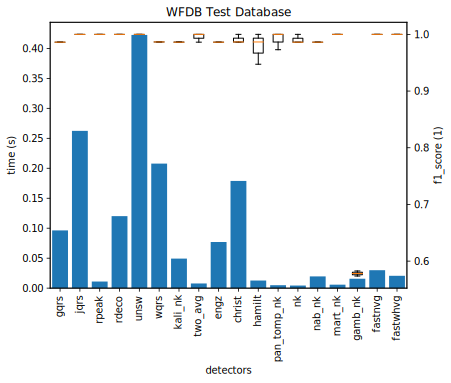

In [139]:
for database in databases:
    print('Database: ',database.Name)
    runtime = [[] for i in range(len(detectors))]
    sensitivity = [[] for i in range(len(detectors))]
    positive_predictivity = [[] for i in range(len(detectors))]
    f1_score = [[] for i in range(len(detectors))]
    for user in database.Users:
        print('User: ',user.UserName)
        for recording in user.Recordings:
            print('Recording: ',recording.RecordingName)
            for recordingsegment in recording.RecordingSegments:
                evaluations = recordingsegment.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
                for i in range(len(evaluations)):
                    runtime[i].append(evaluations[i].runtime)
                    sensitivity[i].append(evaluations[i].sensitivity)
                    positive_predictivity[i].append(evaluations[i].positive_predictivity)
                    f1_score[i].append(evaluations[i].f1_score)

    data = [np.around([np.mean(time) for time in runtime],decimals=2),np.around([np.min(sens) for sens in sensitivity],decimals=2), np.around([np.min(pos_pred) for pos_pred in positive_predictivity],decimals=2),np.around([np.min(f1) for f1 in f1_score],decimals=2)]
    rows = ["runtime (s)","sensitiv", "pos pred", "f1 score"]
    columns = [detector.short_name for detector in detectors]

    print(pandas.DataFrame(data, rows, columns))

    fig, ax = plt.subplots()
    ax.bar(range(1, len(runtime)+1),[np.mean(time) for time in runtime])
    ax.set_ylabel("time (s)")
    ax2 = ax.twinx()
    ax2.boxplot(f1_score)
    ax2.set_ylabel("f1_score (1)")
    ax.set_xticklabels(columns, rotation = 'vertical')
    ax.set_title(database.Name) 
    ax.set_xlabel("detectors")
      

In [140]:
name = databases[0].Name
recording = databases[0].Users[0].Recordings[0]
signal = recording.WholeSignal
fs = recording.Fs
actual_qrs_complexes = recording.WholeActual_Qrs_Complex
evaluations = recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

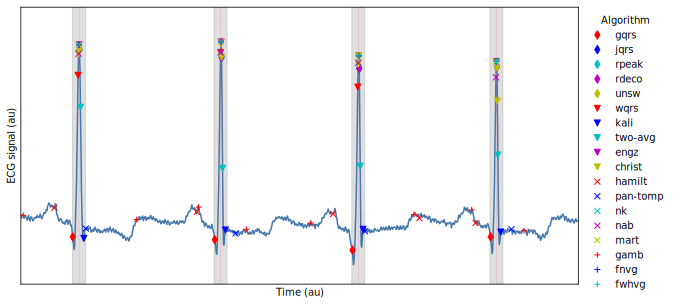

In [141]:
markers = ["d", "v", "x", "+", "*", "^", "<", ">", "1", "2", "3", "4", "8", "s","p", "P", "h", "H", "X", "D", "|", "_", ".", "o"]
colors = ["r", "b", "c", "m", "y"]#, "k"]

fmt = [marker + color for marker in markers for color in colors]

#fmt = ['bo','r<','c^','m>','yv','rx','kd','cp','cx','b>','yx','mx','bx', 'rd', 'r0']
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(signal, color=cmap[0])
#ax.plot(actual_qrs_complexes, signal[actual_qrs_complexes], 'go', label = "Actual QRS Complexes")
for act in actual_qrs_complexes:
    ax.axvspan(act-(tolerance_window_size/2)*fs/1000, act+(tolerance_window_size/2)*fs/1000, alpha=0.25, color='gray')
ax.vlines(x = actual_qrs_complexes, ymax=max(signal), ymin = min(signal), transform=ax.get_xaxis_transform(), color=cmap[1],ls=':', lw=linewidth)
for i in range(len(evaluations)):
    ax.plot(evaluations[i].predicted_peaks, signal[evaluations[i].predicted_peaks], fmt[i],label=detector_rename[evaluations[i].Detector.short_name])
#ax.set_title(name)
ax.set_xlim(250,1400)
ax.set_xlabel("Time (au)")
ax.set_ylabel('ECG signal (au)')
ax.tick_params(left = False, right = False , bottom=False, labelleft = False, labelbottom=False)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1),frameon=False, title='Algorithm')
#fig.legend()
plt.savefig('data_autosave/real_exemplary_signal_v003.svg')

# Experiment - Real Databases

## Setup

### Evaluate Databases

#### TELE - Telehealth Database
The database is evaluated. All algorithms are run for every signal and for each of them different metrics are created. This step takes quite long. It can be skipped by loading a previus version of the evaluated database below.

In [142]:
if evaluate_TELE_database:
    print('Database: ',telehealth_environment_database.Name)
    users = telehealth_environment_database.Users
    for j in range(len(users)):
        print('User: ',users[j].UserName)
        print('User number {} of {}'.format(j+1, len(users)))
        for recording in users[j].Recordings:
            print('Recording: ',recording.RecordingName)
            recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

Pickle evaluated database for easy use afterwards.

In [143]:
if evaluate_TELE_database:
    filename = 'pickle/telehealth_environment_database_evaluated.pkl'
    file = open(filename, 'wb')
    pickle.dump(telehealth_environment_database, file)
    file.close()

#### ARR - MIT BIH Arrhythmia Database
The database is evaluated. All algorithms are run for every signal and for each of them different metrics are created. This step takes quite long. It can be skipped by loading a previus version of the evaluated database below.

In [144]:
if evaluate_ARR_database:
    filename = 'pickle/mit_bih_arrhythmia_database_evaluated.pkl'
    if os.path.exists(filename):
        file = open(filename, 'rb')
        mit_bih_arrhythmia_database = pickle.load(file)
        file.close()

In [145]:
if evaluate_ARR_database:
    filename = 'pickle/mit_bih_arrhythmia_database_evaluated.pkl'
    print('Database: ',mit_bih_arrhythmia_database.Name)
    users = mit_bih_arrhythmia_database.Users
    for j in range(len(users)):
        #if users[j].Recordings[-1].RecordingSegments[-1].Evaluations:
        #    continue
        print('User: ',users[j].UserName)
        for recording in users[j].Recordings:
            #recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
            print('Recording: ',recording.RecordingName)
            for recordingsegment in recording.RecordingSegments:
                recordingsegment.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
        file = open(filename, 'wb')
        pickle.dump(mit_bih_arrhythmia_database, file)
        file.close()

Pickle evaluated database for easy use afterwards.

In [146]:
if evaluate_ARR_database:
    filename = 'pickle/mit_bih_arrhythmia_database_evaluated.pkl'
    file = open(filename, 'wb')
    pickle.dump(mit_bih_arrhythmia_database, file)
    file.close()

#### SIN - MIT-BIH Normal Sinus Rhythm Database
The database is evaluated. All algorithms are run for every signal and for each of them different metrics are created. This step takes quite long. It can be skipped by loading a previus version of the evaluated database below.

In [147]:
if evaluate_SIN_database:
    filename = 'pickle/mit_bih_normal_sinus_rhythm_database_evaluated.pkl'
    if os.path.exists(filename):
        file = open(filename, 'rb')
        mit_bih_normal_sinus_rhythm_database = pickle.load(file)
        file.close()

In [148]:
filename = 'pickle/mit_bih_normal_sinus_rhythm_database_evaluated.pkl'
if evaluate_SIN_database:
    print('Database: ',mit_bih_normal_sinus_rhythm_database.Name)
    users = mit_bih_normal_sinus_rhythm_database.Users
    for j in range(len(users)):
        #if users[j].Recordings[-1].RecordingSegments[-1].Evaluations:
        #    continue
        print('User: ',users[j].UserName)
        for recording in users[j].Recordings:
            #recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
            print('Recording: ',recording.RecordingName)
            for recordingsegment in recording.RecordingSegments:
                #print('New RecordingSegment')
                recordingsegment.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
        file = open(filename, 'wb')
        pickle.dump(mit_bih_normal_sinus_rhythm_database, file)
        file.close()

Pickle evaluated database for easy use afterwards.

In [149]:
if evaluate_SIN_database:
    filename = 'pickle/mit_bih_normal_sinus_rhythm_database_evaluated.pkl'
    file = open(filename, 'wb')
    pickle.dump(mit_bih_normal_sinus_rhythm_database, file)
    file.close()

#### HIGH - High Quality Database
The database is evaluated. All algorithms are run for every signal and for each of them different metrics are created. This step takes quite long. It can be skipped by loading a previus version of the evaluated database below.

In [150]:
if evaluate_HIGH_database:
    print('Database: ',high_quality_database.Name)
    users = high_quality_database.Users
    for j in range(len(users)):
        print('User: ',users[j].UserName)
        for recording in users[j].Recordings:
            recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
            print('Recording: ',recording.RecordingName)
            for recordingsegment in recording.RecordingSegments:
                recordingsegment.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

Pickle evaluated database for easy use afterwards.

In [151]:
if evaluate_HIGH_database:
    filename = 'pickle/high_quality_database_evaluated.pkl'
    file = open(filename, 'wb')
    pickle.dump(high_quality_database, file)
    file.close()

#### LOW - Low Quality Database
The database is evaluated. All algorithms are run for every signal and for each of them different metrics are created. This step takes quite long. It can be skipped by loading a previus version of the evaluated database below.

In [152]:
if evaluate_LOW_database:
    print('Database: ',low_quality_database.Name)
    users = low_quality_database.Users
    for j in range(len(users)):
        print('User: ',users[j].UserName)
        for recording in users[j].Recordings:
            recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
            print('Recording: ',recording.RecordingName)
            for recordingsegment in recording.RecordingSegments:
                recordingsegment.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

Pickle evaluated database for easy use afterwards.

In [153]:
if evaluate_LOW_database:
    filename = 'pickle/low_quality_database_evaluated.pkl'
    file = open(filename, 'wb')
    pickle.dump(low_quality_database, file)
    file.close()

#### SAFER - SAFER Trial Database
The database is evaluated. All algorithms are run for every signal and for each of them different metrics are created. This step takes quite long. It can be skipped by loading a previus version of the evaluated database below.

In [154]:
if evaluate_SAFER_database:
    print('Database: ',safer_trial_database.Name)
    users = safer_trial_database.Users
    for j in range(len(users)):
        print('User: ',users[j].UserName)
        for recording in users[j].Recordings:
            print('Recording: ',recording.RecordingName)
            recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

Pickle evaluated database for easy use afterwards.

In [155]:
if evaluate_SAFER_database:
    filename = 'pickle/safer_trial_database_evaluated.pkl'
    file = open(filename, 'wb')
    pickle.dump(safer_trial_database, file)
    file.close()

### Load Databases

Databases are loaded from their pickled format if they have not been evaluated recently and if a pickled file exists that can be read.

In [156]:
databases = []

filename = 'pickle/telehealth_environment_database_evaluated.pkl'
if not evaluate_TELE_database and os.path.exists(filename):
    file = open(filename, 'rb')
    telehealth_environment_database = pickle.load(file)
    file.close()
    databases.append(telehealth_environment_database)
elif evaluate_TELE_database and telehealth_environment_database:
    databases.append(telehealth_environment_database)

filename = 'pickle/mit_bih_arrhythmia_database_evaluated.pkl'
if not evaluate_ARR_database and os.path.exists(filename):
    file = open(filename, 'rb')
    mit_bih_arrhythmia_database = pickle.load(file)
    file.close()
    databases.append(mit_bih_arrhythmia_database)
elif evaluate_ARR_database and mit_bih_arrhythmia_database:
    databases.append(mit_bih_arrhythmia_database)

filename = 'pickle/mit_bih_normal_sinus_rhythm_database_evaluated.pkl'
if not evaluate_SIN_database and os.path.exists(filename):
    file = open(filename, 'rb')
    mit_bih_normal_sinus_rhythm_database = pickle.load(file)
    file.close()
    databases.append(mit_bih_normal_sinus_rhythm_database)
elif evaluate_SIN_database and mit_bih_normal_sinus_rhythm_database:
    databases.append(mit_bih_normal_sinus_rhythm_database)


filename = 'pickle/high_quality_database_evaluated.pkl'
if not evaluate_HIGH_database and os.path.exists(filename):
    file = open(filename, 'rb')
    high_quality_database = pickle.load(file)
    file.close()
    databases.append(high_quality_database)
elif evaluate_HIGH_database and high_quality_database:
    databases.append(high_quality_database)


filename = 'pickle/low_quality_database_evaluated.pkl'
if not evaluate_LOW_database and os.path.exists(filename):
    file = open(filename, 'rb')
    low_quality_database = pickle.load(file)
    file.close()
    databases.append(low_quality_database)
elif evaluate_LOW_database and low_quality_database:
    databases.append(low_quality_database)

filename = 'pickle/safer_trial_database_evaluated.pkl'
if not evaluate_SAFER_database and os.path.exists(filename):
    file = open(filename, 'rb')
    safer_trial_database = pickle.load(file)
    file.close()
    databases.append(safer_trial_database)
elif evaluate_SAFER_database and safer_trial_database:
    databases.append(safer_trial_database)

Remove SAFER-AF-LOW dataset from analysis

In [157]:
database_no = 0
for database in databases:
    # for safer dataset
    if database.Name == 'SAFER Trial Database':
        users_to_remove = []
        user_no = 0
        for user in database.Users:
            if user.Recordings[0].AF_SR == 'AF' and user.Recordings[0].Quality == 'LOW':
                users_to_remove.append(user_no)
            user_no = user_no+1
        print('Should have kept {} recordings'.format(user_no - len(users_to_remove)))
        for index in sorted(users_to_remove, reverse=True):
            databases[database_no].Users.pop(index)
        no_kept = 0
        database = databases[database_no]
        for user in database.Users:
            no_kept +=1
        print('Actually kept {} recordings'.format(no_kept))
    database_no +=1
    


Should have kept 479 recordings
Actually kept 479 recordings


Some statistics for each database including the number of beats and the number of users in the database are shown.

In [158]:
for database in databases:
    beats = 0
    SAFER_beats = [0 for i in range(4)]
    SAFER_users = [0 for i in range(4)]
    SAFER_female_recs = [0 for i in range(4)]
    SAFER_male_recs = [0 for i in range(4)]
    SAFER_female_pts = [0 for i in range(4)]
    SAFER_male_pts = [0 for i in range(4)]
    SAFER_names = ['' for i in range(4)]
    SAFER_ptID_0 = []
    SAFER_ptID_1 = []
    SAFER_ptID_2 = []
    SAFER_ptID_3 = []
    for user in database.Users:
        if database.Name == 'SAFER Trial Database':
            group_no = 99
            if user.Recordings[0].AF_SR == 'AF' and user.Recordings[0].Quality == 'HIGH':
                group_no = 0
            elif user.Recordings[0].AF_SR == 'AF' and user.Recordings[0].Quality == 'LOW':
                group_no = 1
            elif user.Recordings[0].AF_SR == 'nonAF' and user.Recordings[0].Quality == 'HIGH':
                group_no = 2
            elif user.Recordings[0].AF_SR == 'nonAF' and user.Recordings[0].Quality == 'LOW':
                group_no = 3
            SAFER_users[group_no] += 1
 
        for recording in user.Recordings:
            beats = beats + len(recording.WholeActual_Qrs_Complex)
            if database.Name == 'SAFER Trial Database':
                new_pt = 0
                group_no = 99
                if recording.AF_SR == 'AF' and recording.Quality == 'HIGH':
                    group_no = 0
                    if recording.AdditionalInfo not in SAFER_ptID_0:
                        SAFER_ptID_0.append(recording.AdditionalInfo)
                        new_pt = 1
                elif recording.AF_SR == 'AF' and recording.Quality == 'LOW':
                    group_no = 1
                    if recording.AdditionalInfo not in SAFER_ptID_1:
                        SAFER_ptID_1.append(recording.AdditionalInfo)
                        new_pt = 1
                elif recording.AF_SR == 'nonAF' and recording.Quality == 'HIGH':
                    group_no = 2
                    if recording.AdditionalInfo not in SAFER_ptID_2:
                        SAFER_ptID_2.append(recording.AdditionalInfo)
                        new_pt = 1
                elif recording.AF_SR == 'nonAF' and recording.Quality == 'LOW':
                    group_no = 3
                    if recording.AdditionalInfo not in SAFER_ptID_3:
                        SAFER_ptID_3.append(recording.AdditionalInfo)
                        new_pt = 1
                SAFER_names[group_no] = database.Name + '-' + recording.AF_SR + '-' + recording.Quality
                SAFER_beats[group_no] = SAFER_beats[group_no] + len(recording.WholeActual_Qrs_Complex)
                if recording.Gender == 'F':
                    SAFER_female_recs[group_no] += 1
                    if new_pt == 1:
                        SAFER_female_pts[group_no] +=1
                elif recording.Gender == 'M':
                    SAFER_male_recs[group_no] += 1
                    if new_pt == 1:
                        SAFER_male_pts[group_no] +=1
 
    if database.Name in ['High Quality Database', 'Low Quality Database']:
        print(database.Name,' has ', beats, ' beats, and ', len(database.Users), ' recordings')
    elif database.Name in ['Telehealth Database']:
        print(database.Name,' has ', beats, ' beats, and ', len(database.Users[0].Recordings), ' recordings')
    else:
        print(database.Name,' has ', beats, ' beats, and ', len(database.Users), ' recordings, ')
 
    if database.Name == 'SAFER Trial Database':
        print('Detailed SAFER results:')
        for i in range(len(SAFER_names)):
            print(SAFER_names[i],' has ', SAFER_beats[i], ' beats, and ', SAFER_users[i], ' recordings (', SAFER_female_recs[i], ' female and ', SAFER_male_recs[i], ' male) from', end =" ")
            if i == 0:
                print(len(np.unique(SAFER_ptID_0)), end =" ")
            elif i == 1:
                print(len(np.unique(SAFER_ptID_1)), end =" ")
            elif i == 2:
                print(len(np.unique(SAFER_ptID_2)), end =" ")
            elif i == 3:
                print(len(np.unique(SAFER_ptID_3)), end =" ")
            print('participants (', SAFER_female_pts[i], 'female and', SAFER_male_pts[i], 'male)')

Telehealth Database  has  5932  beats, and  250  recordings
MIT-BIH Arrhythmia Database  has  112599  beats, and  48  recordings, 
MIT-BIH Normal Sinus Rhythm Database  has  185253  beats, and  18  recordings, 
High Quality Database  has  72315  beats, and  100  recordings
Low Quality Database  has  78518  beats, and  100  recordings
SAFER Trial Database  has  18279  beats, and  479  recordings, 
Detailed SAFER results:
SAFER Trial Database-AF-HIGH  has  8456  beats, and  183  recordings ( 92  female and  91  male) from 48 participants ( 13 female and 35 male)
  has  0  beats, and  0  recordings ( 0  female and  0  male) from 0 participants ( 0 female and 0 male)
SAFER Trial Database-nonAF-HIGH  has  7065  beats, and  199  recordings ( 100  female and  99  male) from 199 participants ( 100 female and 99 male)
SAFER Trial Database-nonAF-LOW  has  2758  beats, and  97  recordings ( 49  female and  48  male) from 97 participants ( 49 female and 48 male)


### Create Dataframe

A `pandas` dataframe is created using the data evaluated and loaded before. The type of some values is changed to a number format.

In [159]:
data_database = []
data_user = []
data_detector = []
data_f1_score = []
data_sensitivity = []
data_positive_predictivity = []
data_failed = []
data_runtime = []
data_gender = []
data_age = []
data_impl = []
data_hr = []

for database in databases:
    fs = database.Users[0].Recordings[0].Fs
    users = database.Users
    if users[0].UserName == "default":
        user_cnt = 0
    for user in users:
        for recording in user.Recordings:
            if (database.Name == 'Telehealth Database') or (database.Name == 'SAFER Trial Database'):
                evaluations = recording.Evaluations
                for evaluation in evaluations:
                    # creating arrays for a data frame
                    if database.Name != 'SAFER Trial Database':
                        data_database.append(database_rename[database.Name])
                    else:
                        name = database_rename[database.Name]
                        name = name + '-' + recording.AF_SR + '-' + recording.Quality
                        data_database.append(name)
                    if user.UserName == "default":
                        data_user.append(str(user_cnt))
                    else:
                        data_user.append(user.UserName)
                    data_detector.append(detector_rename[evaluation.Detector.short_name])
                    data_f1_score.append(evaluation.f1_score)
                    data_sensitivity.append(evaluation.sensitivity)
                    data_positive_predictivity.append(evaluation.positive_predictivity)
                    data_failed.append(evaluation.failed)
                    data_runtime.append(evaluation.runtime*1000)
                    data_gender.append(recording.Gender)
                    data_age.append(recording.Age)
                    data_impl.append(detector_implementation[detector_rename[evaluation.Detector.short_name]])
                    data_hr.append(len(recording.WholeActual_Qrs_Complex)/(len(recording.WholeSignal)/recording.Fs)*60)
                if user.UserName == "default":
                    user_cnt = user_cnt + 1
                continue
            for recordingsegment in recording.RecordingSegments:
                evaluations = recordingsegment.Evaluations
                for evaluation in evaluations:
                    # creating arrays for a data frame
                    data_database.append(database_rename[database.Name])
                    data_user.append(user.UserName)
                    data_detector.append(detector_rename[evaluation.Detector.short_name])
                    data_f1_score.append(evaluation.f1_score)
                    data_sensitivity.append(evaluation.sensitivity)
                    data_positive_predictivity.append(evaluation.positive_predictivity)
                    data_failed.append(evaluation.failed)
                    data_runtime.append(evaluation.runtime*1000)
                    data_gender.append(recording.Gender)
                    data_age.append(recording.Age)
                    data_impl.append(detector_implementation[detector_rename[evaluation.Detector.short_name]])
                    data_hr.append(len(recordingsegment.Actual_Qrs_Complex)/(len(recordingsegment.Signal)/recordingsegment.Fs)*60)

    data_real = pandas.DataFrame(data=np.transpose(np.array([data_database,data_user,data_detector,data_f1_score,data_failed,data_runtime,data_gender,data_age,data_impl,data_sensitivity,data_positive_predictivity,data_hr])),columns=['database','user','detector','f1_score','failed','runtime','gender','age','implementation','sensitivity','positive_predictivity','heart_rate'])
    data_real['f1_score'] = data_real['f1_score'].astype(float)
    data_real['sensitivity'] = data_real['sensitivity'].astype(float)
    data_real['positive_predictivity'] = data_real['positive_predictivity'].astype(float)
    data_real['runtime'] = data_real['runtime'].astype(float)
    data_real['heart_rate'] = data_real['heart_rate'].astype(float)
    data_real['failed'] = data_real['failed'].astype(bool)
    data_real['gender'] = data_real['gender'].str.replace('M','1')
    data_real['gender'] = data_real['gender'].str.replace('F','2')
    data_real['gender'] = data_real['gender'].astype(float)
    data_real.sort_values(by='detector',inplace=True)

In [160]:
data_real = data_real.groupby(["database","detector","user"]).median().reset_index()
data_real['gender'] = data_real['gender'].astype(str).str.replace('1.0','M')
data_real['gender'] = data_real['gender'].astype(str).str.replace('2.0','F')
data_real.head()

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/2246672059.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_real['gender'] = data_real['gender'].astype(str).str.replace('1.0','M')
/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/2246672059.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data_real['gender'] = data_real['gender'].astype(str).str.replace('2.0','F')


,database,detector,user,f1_score,failed,runtime,gender,sensitivity,positive_predictivity,heart_rate
0,ARR,christ,100,0.986667,0.0,162.497044,M,1.000000,1.000000,74.006852
1,ARR,christ,101,0.983607,0.0,162.410021,F,1.000000,0.967742,62.005741
2,ARR,christ,102,1.000000,0.0,161.214113,F,1.000000,1.000000,72.006667
3,ARR,christ,103,0.985915,0.0,161.046743,M,1.000000,1.000000,68.006297
4,ARR,christ,104,0.948718,0.0,159.893990,F,0.957447,0.973684,74.006852


## Results

#### Overall F1 results

This graph shows a boxplot of the general F1-results split up by algorithm.

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/4220459370.py:11: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_overall.xlsx', engine='openpyxl')


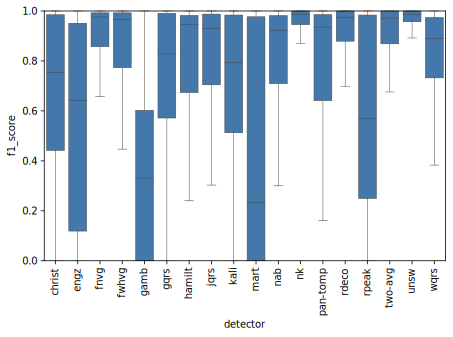

In [161]:
data_plot = data_real
x = 'detector'
y = 'f1_score'

fig, ax = plt.subplots()
sns.boxplot(x='detector', y='f1_score', data=data_plot, ax=ax,saturation=saturation,linewidth=linewidth,flierprops=flierprops, color=cmap[0],showfliers=False)
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(bottom=0, top=1)
plt.tight_layout()
plt.savefig('data_autosave/real_overall.svg')
data_plot.groupby([x]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_overall.xlsx', engine='openpyxl')
pass

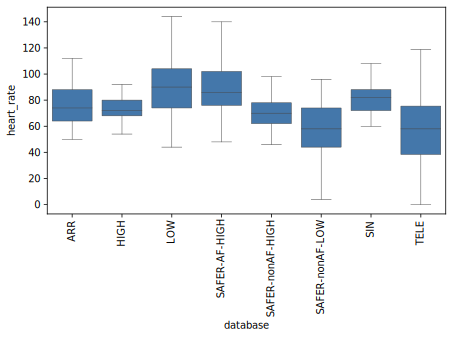

In [162]:
data_plot = data_real
x = 'database'
y = 'heart_rate'

fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data_plot, ax=ax,saturation=saturation,linewidth=linewidth,flierprops=flierprops, color=cmap[0],showfliers=False)
ax.tick_params(axis='x', rotation=90)
#ax.set_ylim(bottom=0, top=1)
plt.tight_layout()
#plt.savefig('data_autosave/real_overall.svg')
#data_plot.groupby([x]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_overall.xlsx', engine='openpyxl')
pass

#### Database Comparison

This graph shows boxplots for the algorithm performance differentiated by database. Additionally Mann-Whitney U tests were performed to test for statistically significant differences.

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/3579324788.py:23: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_database_comparison.xlsx', engine='openpyxl')


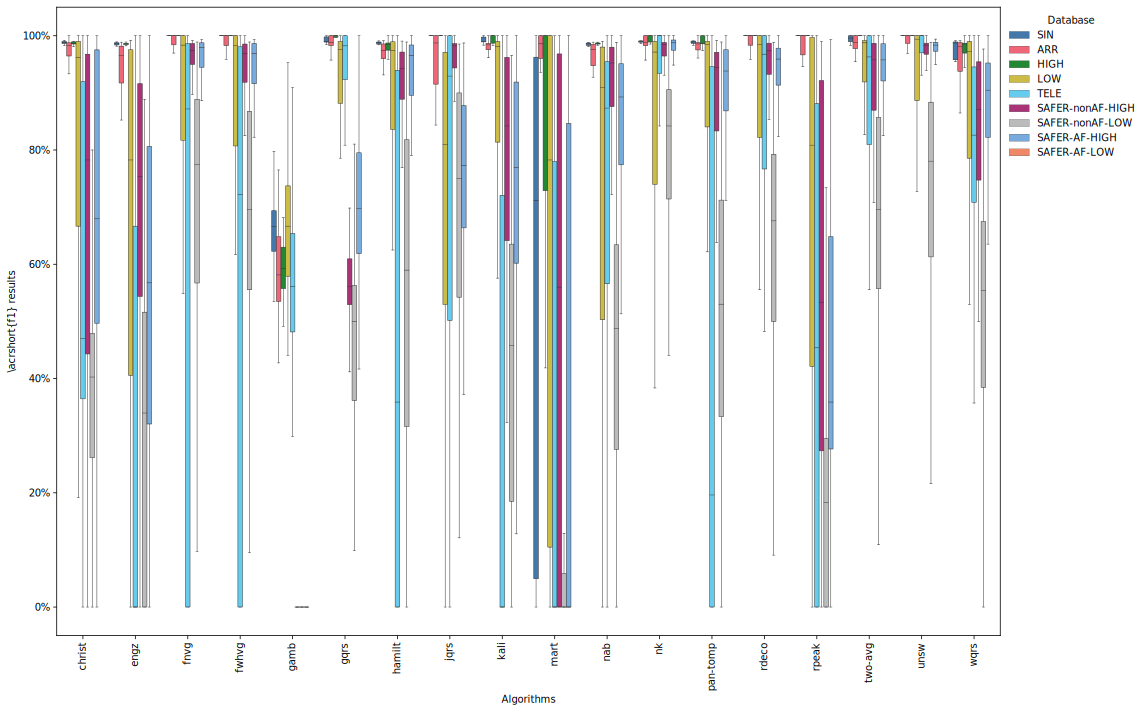

In [163]:
#data_plot = data_real[data_real['detector'].isin(['hamilt', 'nk', 'rdeco', 'two-avg', 'unsw'])]
data_plot = data_real
box_pairs = []
detectors_names = data_plot['detector'].unique()
databases_names = data_plot['database'].unique()
x = 'detector'
y = 'f1_score'
hue = 'database'
if os.path.exists('pickle/safer_trial_database_evaluated.pkl'):
    hue_order = ['SIN','ARR','HIGH','LOW', 'TELE','SAFER-nonAF-HIGH', 'SAFER-nonAF-LOW', 'SAFER-AF-HIGH', 'SAFER-AF-LOW']
else:
    hue_order = ['SIN','ARR','HIGH','LOW', 'TELE']

fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),frameon=False,title='Database')
ax.tick_params(axis='x', rotation=90)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
ax.set_ylabel('\\acrshort{f1} results')
ax.set_xlabel('Algorithms')
plt.tight_layout()
plt.savefig('data_autosave/real_database_comparison.svg')
data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_database_comparison.xlsx', engine='openpyxl')
pass

Performance expressed as F1 score

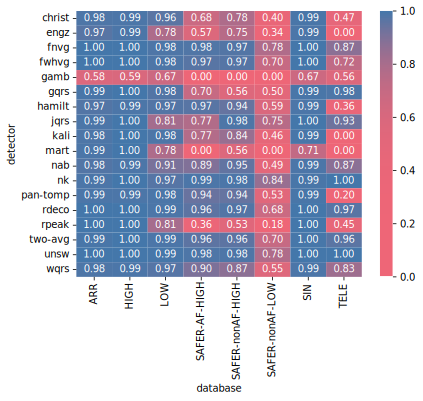

In [164]:
hue = 'f1_score'
x = 'detector'
y = 'database'
data_plot = data_real.groupby([x,y]).median()
#data_plot.head()
data_plot = data_plot[[hue]].reset_index()
cmap_cont = matplotlib.colors.LinearSegmentedColormap.from_list('custom colors', [cmap[1],cmap[0]], N=256,gamma=4)
sns.heatmap(data_plot.pivot(x,y,hue), annot=True, fmt=".2f", cmap=cmap_cont)
plt.savefig('data_autosave/real_database_heatmap_f1.svg')
pass

In [165]:
# attempt at sorting by database

sort_by_database = False
if sort_by_database:
    data_temp = data_real
    data_temp['sort'] = 0
    data_temp.loc[data_temp['database'] == 'SIN', 'sort'] = 1
    data_temp.loc[data_temp['database'] == 'ARR', 'sort'] = 2
    data_temp.loc[data_temp['database'] == 'HIGH', 'sort'] = 3
    data_temp.loc[data_temp['database'] == 'LOW', 'sort'] = 4
    data_temp.loc[data_temp['database'] == 'TELE', 'sort'] = 5
    data_temp.loc[data_temp['database'] == 'SAFER-nonAF-HIGH', 'sort'] = 6
    data_temp.loc[data_temp['database'] == 'SAFER-nonAF-LOW', 'sort'] = 7
    data_temp.loc[data_temp['database'] == 'SAFER-AF-HIGH', 'sort'] = 8
    data_temp.loc[data_temp['database'] == 'SAFER-AF-LOW', 'sort'] = 9
    data_temp.sort_values(by=['sort'])
    data_plot = data_temp.groupby(['detector','database','sort']).median()
    data_plot.sort_values(by=['sort'])
    data_plot = data_plot[[hue]].reset_index()
    cmap_cont = matplotlib.colors.LinearSegmentedColormap.from_list('custom colors', [cmap[1],cmap[0]], N=256,gamma=4)
    sns.heatmap(data_plot.pivot('detector',columns=['sort'],values=hue), annot=True, fmt=".2f", cmap=cmap_cont)
    plt.xlabel('Dataset')




Performance expressed as sensitivity

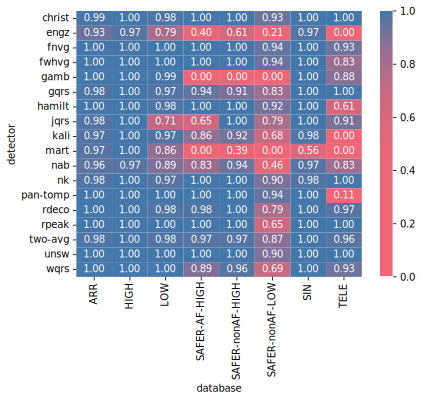

In [166]:
hue = 'sensitivity'
x = 'detector'
y = 'database'
data_plot = data_real.groupby([x,y]).median()
#data_plot.head()
data_plot = data_plot[[hue]].reset_index()
cmap_cont = matplotlib.colors.LinearSegmentedColormap.from_list('custom colors', [cmap[1],cmap[0]], N=256,gamma=4)
sns.heatmap(data_plot.pivot(x,y,hue), annot=True, fmt=".2f", cmap=cmap_cont)
plt.savefig('data_autosave/real_database_heatmap_sensitivity.svg')
pass

Performance expressed as PPV

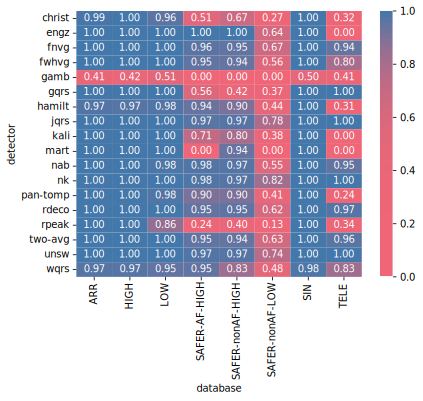

In [167]:
hue = 'positive_predictivity'
x = 'detector'
y = 'database'
data_plot = data_real.groupby([x,y]).median()
#data_plot.head()
data_plot = data_plot[[hue]].reset_index()
cmap_cont = matplotlib.colors.LinearSegmentedColormap.from_list('custom colors', [cmap[1],cmap[0]], N=256,gamma=4)
sns.heatmap(data_plot.pivot(x,y,hue), annot=True, fmt=".2f", cmap=cmap_cont)
plt.savefig('data_autosave/real_database_heatmap_pos_pred.svg')
pass

Testing for significant differences

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

wqrs_HIGH v.s. wqrs_LOW: Mann-Whitney-Wilcoxon test two-sided, P_val=2.017e-01 U_stat=5.469e+03
fwhvg_LOW v.s. fwhvg_TELE: Mann-Whitney-Wilcoxon test two-sided, P_val=1.098e-09 U_stat=1.746e+04
gamb_LOW v.s. gamb_TELE: Mann-Whitney-Wilcoxon test two-sided, P_val=2.076e-08 U_stat=1.714e+04
gamb_SAFER-nonAF-HIGH v.s. gamb_SAFER-nonAF-LOW: Mann-Whitney-Wilcoxon test two-sided, P_val=1.000e+00 U_stat=9.652e+03
gqrs_SIN v.s. gqrs_ARR: Mann-Whitney-Wilcoxon test two-sided, P_val=5.126e-01 U_stat=4.770e+02
gqrs_LOW v.s. gqrs_TELE: Mann-Whitney-Wilcoxon test two-sided, P_val=9.704e-04 U_stat=9.625e+03
gqrs_SAFER-nonAF-HIGH v.s. gqrs_SAFER-nonAF-LOW: Mann-Whitney-Wilcoxon test two-sided, P_val=6.662e-10 U_stat=1.392e+04
hamilt_SIN v.s. hamilt_ARR: Mann-Whitney-Wilcoxon test two-sided, P_val=7.712e-04 U_stat=6.660e+02
hamilt_LOW v.s. 

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/77794080.py:40: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_database_comparison_additional_tests.xlsx', engine='openpyxl')


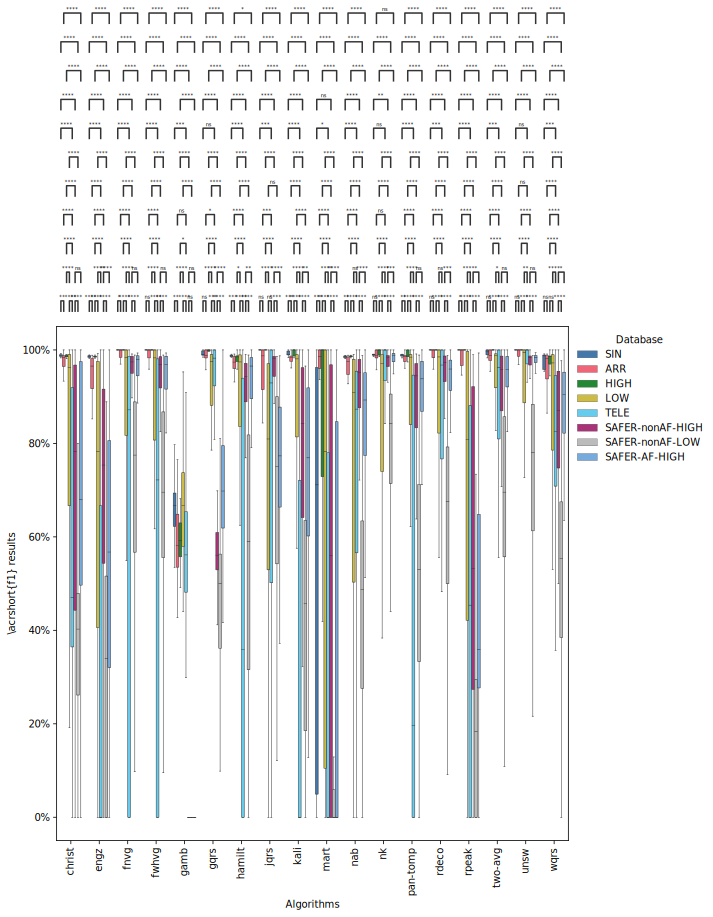

In [168]:
fontsize = 5
data_plot = data_real
box_pairs = []
detectors_names = data_plot['detector'].unique()
databases_names = data_plot['database'].unique()
for detector in detectors_names:
    box_pairs.append(((detector, 'SIN'), (detector, 'ARR')))
    box_pairs.append(((detector, 'HIGH'), (detector, 'LOW')))
    box_pairs.append(((detector, 'SIN'), (detector, 'TELE')))
    box_pairs.append(((detector, 'ARR'), (detector, 'TELE')))
    box_pairs.append(((detector, 'HIGH'), (detector, 'TELE')))
    box_pairs.append(((detector, 'LOW'), (detector, 'TELE')))
    if os.path.exists('pickle/safer_trial_database_evaluated.pkl'):
        box_pairs.append(((detector, 'SIN'), (detector, 'SAFER-nonAF-HIGH')))
        box_pairs.append(((detector, 'SIN'), (detector, 'SAFER-nonAF-LOW')))
        box_pairs.append(((detector, 'ARR'), (detector, 'SAFER-AF-HIGH')))
        box_pairs.append(((detector, 'HIGH'), (detector, 'SAFER-nonAF-HIGH')))
        box_pairs.append(((detector, 'HIGH'), (detector, 'SAFER-AF-HIGH')))
        box_pairs.append(((detector, 'LOW'), (detector, 'SAFER-nonAF-LOW')))
        box_pairs.append(((detector, 'SAFER-nonAF-HIGH'), (detector, 'SAFER-nonAF-LOW')))
        box_pairs.append(((detector, 'SAFER-nonAF-HIGH'), (detector, 'SAFER-AF-HIGH')))
x = 'detector'
y = 'f1_score'
hue = 'database'
if os.path.exists('pickle/safer_trial_database_evaluated.pkl'):
    hue_order = ['SIN','ARR','HIGH','LOW', 'TELE','SAFER-nonAF-HIGH', 'SAFER-nonAF-LOW', 'SAFER-AF-HIGH']
else:
    hue_order = ['SIN','ARR','HIGH','LOW', 'TELE']

fig, ax = plt.subplots(figsize=(10, 16))
sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),frameon=False,title='Database')
ax.tick_params(axis='x', rotation=90)
test = add_stat_annotation(ax, data=data_plot, x=x, y=y, hue=hue,hue_order=hue_order, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction=None,fontsize=fontsize)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
ax.set_ylabel('\\acrshort{f1} results')
ax.set_xlabel('Algorithms')
plt.tight_layout()
plt.savefig('data_autosave/real_database_comparison_additional_tests.svg')
data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_database_comparison_additional_tests.xlsx', engine='openpyxl')
pass

#### Influence of Sex

Only signals from databases where sex was available are used for this graph. The data is split up into results for female and male participants. Mann-Whitney U test to test for statistically significant differences are implemented.

##### For SIN database

90  male samples (across all detectors)
234  female samples (across all detectors)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mart_M v.s. mart_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.850e+01
nab_M v.s. nab_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.800e+01
nk_M v.s. nk_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.706e-01 U_stat=1.100e+01
pan-tomp_M v.s. pan-tomp_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.250e+01
rdeco_M v.s. rdeco_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.200e+01
rpeak_M v.s. rpeak_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+01
two-avg_M v.s. two-avg_F: Mann-Whitney-

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/1895127474.py:27: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_sin.xlsx', engine='openpyxl')


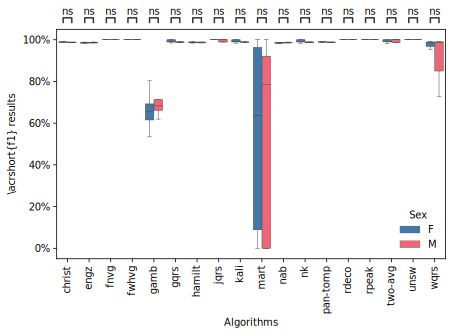

In [169]:
db_name = 'SIN'
if not data_real[data_real['database'] == db_name].empty:
    box_pairs = []
    for detector in data_real['detector'].unique():
        box_pairs.append(((detector, 'F'), (detector, 'M')))
    x = 'detector'
    y = 'f1_score'
    hue = 'gender'
    hue_order = ['F', 'M']
    data_plot = data_real[(data_real[hue] != None) & (data_real['database'] == db_name)] # & (data_real['user'].isin(['16265','16272','16273','16420','16483','16539','16773','16786','19090','19093']))]


    print(len(data_plot[(data_plot['gender'] == 'M')]), ' male samples (across all detectors)')
    print(len(data_plot[(data_plot['gender'] == 'F')]), ' female samples (across all detectors)')

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
    sns.move_legend(ax, "lower right", frameon=False,title='Sex')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(),va='top')
    test = add_stat_annotation(ax, data=data_plot, x=x, y=y, hue=hue, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction='bonferroni',)
    ax.set_ylabel('\\acrshort{f1} results')
    ax.set_xlabel('Algorithms')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
    plt.tight_layout()
    plt.savefig('data_autosave/real_sex_sin.svg')
    data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_sin.xlsx', engine='openpyxl')
    pass

##### For ARR database

468  male samples (across all detectors)
396  female samples (across all detectors)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mart_M v.s. mart_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.830e+02
nab_M v.s. nab_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.370e+02
nk_M v.s. nk_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.030e+02
pan-tomp_M v.s. pan-tomp_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.734e-01 U_stat=4.115e+02
rdeco_M v.s. rdeco_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.175e+02
rpeak_M v.s. rpeak_F: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.775e+02
two-avg_M v.s. two-avg_F: Mann-Whitney

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/2422680646.py:26: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_arr.xlsx', engine='openpyxl')


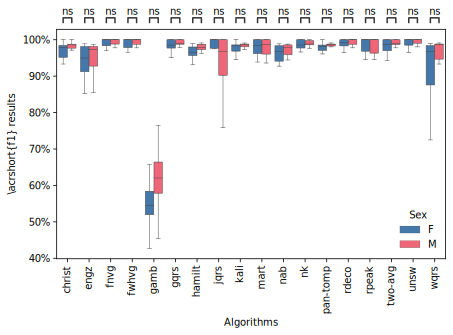

In [170]:
db_name = 'ARR'
if not data_real[data_real['database'] == db_name].empty:
    box_pairs = []
    for detector in data_real['detector'].unique():
        box_pairs.append(((detector, 'F'), (detector, 'M')))
    x = 'detector'
    y = 'f1_score'
    hue = 'gender'
    hue_order = ['F', 'M']
    data_plot = data_real[(data_real[hue].notnull()) & (data_real['database'] == db_name)]

    print(len(data_plot[(data_plot['gender'] == 'M')]), ' male samples (across all detectors)')
    print(len(data_plot[(data_plot['gender'] == 'F')]), ' female samples (across all detectors)')

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order, data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
    sns.move_legend(ax, "lower right", frameon=False,title='Sex')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(),va='top')
    test = add_stat_annotation(ax, data=data_plot, x=x, y=y, hue=hue, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction='bonferroni',)
    ax.set_ylabel('\\acrshort{f1} results')
    ax.set_xlabel('Algorithms')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
    plt.tight_layout()
    plt.savefig('data_autosave/real_sex_arr.svg')
    data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_arr.xlsx', engine='openpyxl')
    pass

##### For SAFER database

###### All SAFER

4284  male samples
4338  female samples
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mart_F v.s. mart_M: Mann-Whitney-Wilcoxon test two-sided, P_val=2.317e-01 U_stat=2.697e+04
nab_F v.s. nab_M: Mann-Whitney-Wilcoxon test two-sided, P_val=2.864e-01 U_stat=2.706e+04
nk_F v.s. nk_M: Mann-Whitney-Wilcoxon test two-sided, P_val=9.838e-02 U_stat=3.118e+04
pan-tomp_F v.s. pan-tomp_M: Mann-Whitney-Wilcoxon test two-sided, P_val=9.692e-01 U_stat=2.862e+04
rdeco_F v.s. rdeco_M: Mann-Whitney-Wilcoxon test two-sided, P_val=5.038e-01 U_stat=2.969e+04
rpeak_F v.s. rpeak_M: Mann-Whitney-Wilcoxon test two-sided, P_val=9.526e-01 U_stat=2.877e+04
two-avg_F v.s. two-avg_M: Mann-Whitney-Wilcoxon test two-sided, P_val=3.307e-02 U_stat=3.190e+04
unsw_F v.s. unsw_M: Mann-Whitney-Wilcoxon test two-sided, P_val=5.578e-02 U_stat=3.158e+04
wqrs_F v.s. wqrs_M: Mann-Whitney-Wilcoxon test two-sided

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/2545361843.py:26: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_safer_all.xlsx', engine='openpyxl')


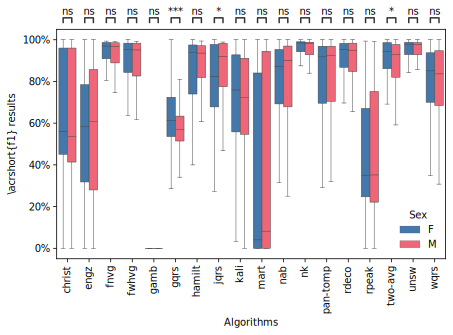

In [171]:
db_name = ['SAFER-AF-HIGH', 'SAFER-AF-LOW', 'SAFER-nonAF-HIGH', 'SAFER-nonAF-LOW']
if not data_real[data_real['database'].isin(db_name)].empty:
    box_pairs = []
    for detector in data_real['detector'].unique():
        box_pairs.append(((detector, 'F'), (detector, 'M')))
    x = 'detector'
    y = 'f1_score'
    hue = 'gender'
    hue_order = ['F', 'M']
    data_plot = data_real[(data_real[hue].notnull()) & (data_real['database'].isin(db_name))]

    print(len(data_plot[(data_plot['gender'] == 'M')]), ' male samples')
    print(len(data_plot[(data_plot['gender'] == 'F')]), ' female samples')

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
    sns.move_legend(ax, "lower right", frameon=False,title='Sex')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(),va='top')
    test = add_stat_annotation(ax, data=data_plot, x=x, y=y, hue=hue, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction=None,)
    ax.set_ylabel('\\acrshort{f1} results')
    ax.set_xlabel('Algorithms')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
    plt.tight_layout()
    plt.savefig('data_autosave/real_sex_safer_all.svg')
    data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_safer_all.xlsx', engine='openpyxl')
    pass

###### High Quality SAFER

3420  male samples
3456  female samples
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mart_F v.s. mart_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.701e+04
nab_F v.s. nab_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.656e+04
nk_F v.s. nk_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.022e+04
pan-tomp_F v.s. pan-tomp_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.806e+04
rdeco_F v.s. rdeco_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.900e+04
rpeak_F v.s. rpeak_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.783e+04
two-avg_F v.s. two-avg_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni cor

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/1626792228.py:26: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_safer_high.xlsx', engine='openpyxl')


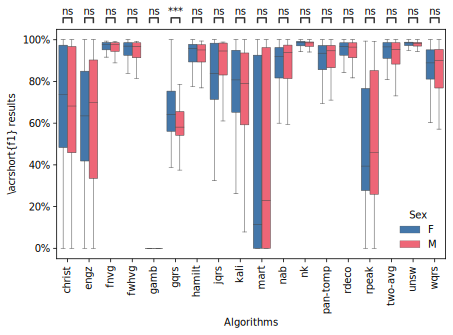

In [172]:
db_name = ['SAFER-AF-HIGH', 'SAFER-nonAF-HIGH']
if not data_real[data_real['database'].isin(db_name)].empty:
    box_pairs = []
    for detector in data_real['detector'].unique():
        box_pairs.append(((detector, 'F'), (detector, 'M')))
    x = 'detector'
    y = 'f1_score'
    hue = 'gender'
    hue_order = ['F', 'M']
    data_plot = data_real[(data_real[hue].notnull()) & (data_real['database'].isin(db_name))]

    print(len(data_plot[(data_plot['gender'] == 'M')]), ' male samples')
    print(len(data_plot[(data_plot['gender'] == 'F')]), ' female samples')

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
    sns.move_legend(ax, "lower right", frameon=False,title='Sex')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(),va='top')
    test = add_stat_annotation(ax, data=data_plot, x=x, y=y, hue=hue, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction='bonferroni',)
    ax.set_ylabel('\\acrshort{f1} results')
    ax.set_xlabel('Algorithms')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
    plt.tight_layout()
    plt.savefig('data_autosave/real_sex_safer_high.svg')
    data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_safer_high.xlsx', engine='openpyxl')
    pass

###### nonAF High Quality SAFER

1782  male samples
1800  female samples
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mart_F v.s. mart_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.590e+03
nab_F v.s. nab_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.988e+03
nk_F v.s. nk_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.397e+03
pan-tomp_F v.s. pan-tomp_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.986e+03
rdeco_F v.s. rdeco_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.609e+03
rpeak_F v.s. rpeak_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.819e+03
two-avg_F v.s. two-avg_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni cor

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/1746199971.py:26: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_safer_high_sr.xlsx', engine='openpyxl')


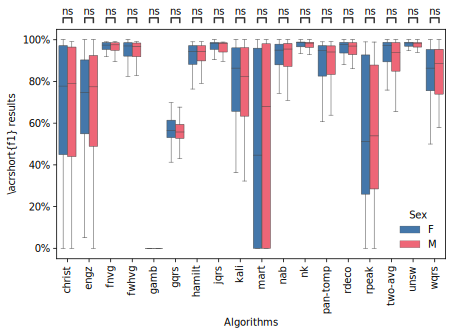

In [173]:
db_name = ['SAFER-nonAF-HIGH']
if not data_real[data_real['database'].isin(db_name)].empty:
    box_pairs = []
    for detector in data_real['detector'].unique():
        box_pairs.append(((detector, 'F'), (detector, 'M')))
    x = 'detector'
    y = 'f1_score'
    hue = 'gender'
    hue_order = ['F', 'M']
    data_plot = data_real[(data_real[hue].notnull()) & (data_real['database'].isin(db_name))]

    print(len(data_plot[(data_plot['gender'] == 'M')]), ' male samples')
    print(len(data_plot[(data_plot['gender'] == 'F')]), ' female samples')

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
    sns.move_legend(ax, "lower right", frameon=False,title='Sex')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(),va='top')
    test = add_stat_annotation(ax, data=data_plot, x=x, y=y, hue=hue, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction='bonferroni',)
    ax.set_ylabel('\\acrshort{f1} results')
    ax.set_xlabel('Algorithms')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
    plt.tight_layout()
    plt.savefig('data_autosave/real_sex_safer_high_sr.svg')
    data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_safer_high_sr.xlsx', engine='openpyxl')
    pass

###### AF High Quality SAFER

1638  male samples
1656  female samples
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mart_F v.s. mart_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.848e+03
nab_F v.s. nab_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.343e-01 U_stat=3.406e+03
nk_F v.s. nk_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.772e+03
pan-tomp_F v.s. pan-tomp_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.084e+03
rdeco_F v.s. rdeco_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.028e+03
rpeak_F v.s. rpeak_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.232e+03
two-avg_F v.s. two-avg_M: Mann-Whitney-Wilcoxon test two-sided with Bonferroni cor

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/3211667306.py:26: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_safer_high_af.xlsx', engine='openpyxl')


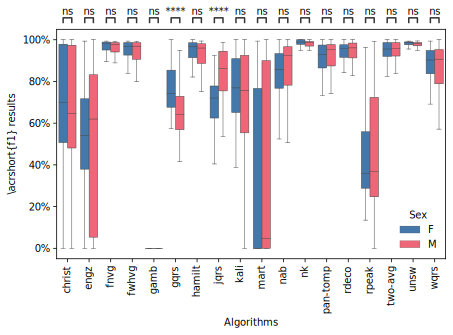

In [174]:
db_name = ['SAFER-AF-HIGH']
if not data_real[data_real['database'].isin(db_name)].empty:
    box_pairs = []
    for detector in data_real['detector'].unique():
        box_pairs.append(((detector, 'F'), (detector, 'M')))
    x = 'detector'
    y = 'f1_score'
    hue = 'gender'
    hue_order = ['F', 'M']
    data_plot = data_real[(data_real[hue].notnull()) & (data_real['database'].isin(db_name))]

    print(len(data_plot[(data_plot['gender'] == 'M')]), ' male samples')
    print(len(data_plot[(data_plot['gender'] == 'F')]), ' female samples')

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
    sns.move_legend(ax, "lower right", frameon=False,title='Sex')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(),va='top')
    test = add_stat_annotation(ax, data=data_plot, x=x, y=y, hue=hue, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction='bonferroni',)
    ax.set_ylabel('\\acrshort{f1} results')
    ax.set_xlabel('Algorithms')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
    plt.tight_layout()
    plt.savefig('data_autosave/real_sex_safer_high_af.svg')
    data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_sex_safer_high_af.xlsx', engine='openpyxl')
    pass

#### Runtime Investigation

The runtime per algorithm is investigated with the bar height showing the median. Errorbars showing the 1st and 3rd quartile are also displayed for each runtime. The runtime is given in seconds. The different colors show, whether a specific algorithm was implemented in Pyhton or in MATLAB.

- Investigate mean runtimes

In [79]:
mean_runtimes = data_real.groupby('detector')['runtime'].median()

# Print the result
print(mean_runtimes)

detector
christ      197.218657
engz         73.796034
fnvg         22.986054
fwhvg        20.531416
gamb          2.138376
gqrs        117.906690
hamilt       17.485976
jqrs          2.999500
kali          2.251863
mart          3.239512
nab          25.779843
nk            2.722740
pan-tomp      2.300620
rdeco         2.451000
rpeak         1.064000
two-avg       9.011865
unsw         37.106500
wqrs        260.761976
Name: runtime, dtype: float64


- Compare median and mean runtimes

In [80]:
a = data_real.groupby('detector')['runtime'].median()
b = data_real.groupby('detector')['runtime'].mean()
c = 100*b/a
c

detector
christ      373.247923
engz         97.275171
fnvg         95.208373
fwhvg        94.104229
gamb         97.438842
gqrs         92.062030
hamilt       99.395034
jqrs        100.634579
kali        106.743659
mart        124.131949
nab          97.988397
nk          118.844626
pan-tomp    107.002052
rdeco       116.994624
rpeak       112.666884
two-avg      91.689076
unsw         87.419869
wqrs         87.929844
Name: runtime, dtype: float64

In [81]:
filtered_data = data_real[data_real['database'].isin(['SAFER-nonAF-LOW'])]
100*filtered_data.groupby('detector')['runtime'].mean()/filtered_data.groupby('detector')['runtime'].median()

detector
christ      2751.548059
engz          80.299735
fnvg         104.371465
fwhvg        105.137586
gamb                inf
gqrs          89.115401
hamilt        99.994679
jqrs         102.818987
kali         102.938512
mart         118.858070
nab          101.984460
nk           102.656256
pan-tomp      99.720183
rdeco        110.692099
rpeak        109.024090
two-avg      100.937732
unsw         101.476351
wqrs         101.565084
Name: runtime, dtype: float64

- Make plot of median runtimes

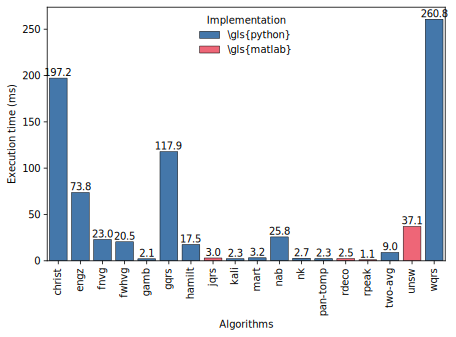

In [82]:
fontsize = 4
data_plot = data_real
x = 'detector'
y = 'runtime'
# hue = 'database'
# if os.path.exists('pickle/safer_trial_database_evaluated.pkl'):
#     hue_order = ['SIN','ARR','HIGH','LOW', 'TELE','SAFER-nonAF-HIGH', 'SAFER-nonAF-LOW', 'SAFER-AF-HIGH', 'SAFER-AF-LOW']
# else:
#     hue_order = ['SIN','ARR','HIGH','LOW', 'TELE']

detectors = np.sort(data_plot['detector'].unique())
cmap_plot = []
for detector in detectors:
    if detector_implementation[detector] == 'Python':
        cmap_plot.append(cmap[0])
    elif detector_implementation[detector] == 'MATLAB':
        cmap_plot.append(cmap[1])
cmap_plot = np.array(cmap_plot)

fig, ax = plt.subplots()#figsize=(10, 7.5))
sns.barplot(data=data_plot, x=x, y=y,ax=ax,linewidth=linewidth, edgecolor=linecolor, estimator=np.median,palette=cmap_plot,saturation=saturation, errorbar=None)#, errorbar=errorbar, errwidth=linewidth,capsize=capsize, errcolor=linecolor) , hue=hue, hue_order=hue_order
#sns.move_legend(ax, "upper center", frameon=False,title='Database')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
ax.set_ylabel('Execution time (ms)')
ax.set_xlabel('Algorithms')
#ax.set_yscale('log')

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.1f', label_type='edge') # , rotation=90, padding=4, fontsize=fontsize)
# ax.set_ylim(top=400)
legend_elements = [matplotlib.patches.Patch(facecolor=cmap[0], edgecolor='k', linewidth=linewidth,
                         label='\\gls{python}'),
                   matplotlib.patches.Patch(facecolor=cmap[1], edgecolor='k', linewidth=linewidth,
                         label='\\gls{matlab}')]
ax.legend(handles=legend_elements, loc='upper center',frameon=False, title='Implementation')
plt.savefig('data_autosave/real_runtime.svg')
#data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/real_runtime.xlsx', engine='openpyxl')
pass

#### Error Investigation

It is investigated which algorithms ran into errors while evaluating specific samples of databases. The results are shown in % errorate per database.

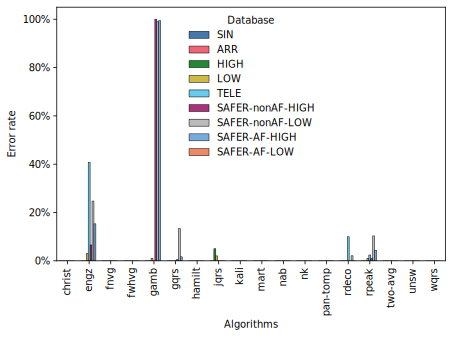

In [83]:
x = 'detector'
y = 'failed'
hue = 'database'
if os.path.exists('pickle/safer_trial_database_evaluated.pkl'):
    hue_order = ['SIN','ARR','HIGH','LOW', 'TELE','SAFER-nonAF-HIGH', 'SAFER-nonAF-LOW', 'SAFER-AF-HIGH', 'SAFER-AF-LOW']
else:
    hue_order = ['SIN','ARR','HIGH','LOW', 'TELE']

fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue,hue_order=hue_order,errorbar=None,palette=cmap, data=data_real,ax=ax,saturation=saturation,linewidth=linewidth, edgecolor=linecolor)
ax.tick_params(axis='x', rotation=90)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
plt.tight_layout()
ax.set_ylabel('Error rate')
ax.set_xlabel('Algorithms')

sns.move_legend(ax, loc='upper center', frameon=False, title='Database')
plt.savefig('data_autosave/real_error.svg')
pass

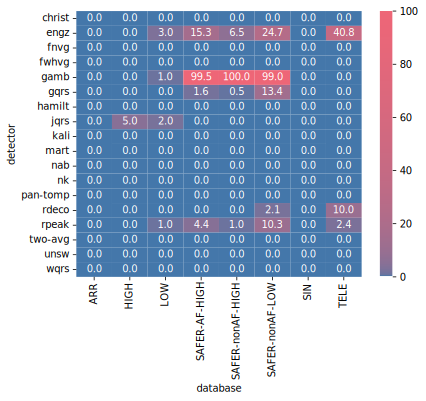

In [84]:
hue = 'failed'
x = 'detector'
y = 'database'
data_plot = data_real.groupby([x,y]).mean()
data_plot = data_plot[[hue]].reset_index()
cmap_cont = matplotlib.colors.LinearSegmentedColormap.from_list('custom colors', [cmap[0],cmap[1]], N=256,gamma=.3)
sns.heatmap(100*data_plot.pivot(x,y,hue), annot=True, fmt=".1f", cmap=cmap_cont)
plt.savefig('data_autosave/real_database_heatmap_error.svg')
pass

/var/folders/c5/wzl7lcbd5ljfz1mr64hqszb40000gn/T/ipykernel_63075/1656481583.py:8: UserWarning: 
The palette list has fewer values (17) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=x, y=y, hue=hue,palette=cmap, data=data_plot,ax=ax,)


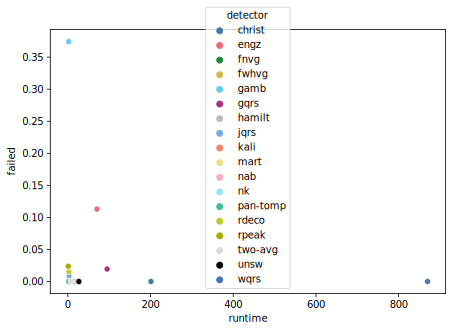

In [85]:
data_plot = data_real.groupby(['detector','database']).mean().reset_index().groupby(['detector']).mean().reset_index()

x = 'runtime'
y = 'failed'
hue = 'detector'

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=hue,palette=cmap, data=data_plot,ax=ax,)
#ax.tick_params(axis='x', rotation=90)
#ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
plt.tight_layout()
#ax.set_ylabel('Errorrate')
#ax.set_xlabel('Algorithms')

#sns.move_legend(ax, loc='upper center', frameon=False, title='Database')
plt.savefig('data_autosave/real_error.svg')
pass

# Experiment - Tolerance Window Size Test

## Setup

- QRS detectors

In [86]:
detectors = []

detectors.append(gqrs_detector)
detectors.append(jqrs_detector)
# detectors.append(visgraph_detector) # takes a lot of time, not used because it takes long and does not give good results
detectors.append(rpeakdetect_detector)
detectors.append(r_deco_detector)
detectors.append(unsw_detector)
# detectors.append(matched_filter_detector) # in ecg-detectors package but not used in neurkit, might be to useless because of frequencies, not used because of frequency issue

detectors.append(wqrs_detector) # differnt implementation of neurokit zong implementation, used because it works, rather slow though
# detectors.append(zong2003_detector) # neurokit detector, different from wqrs, does not work, not used because implementation does not work

# detectors.append(swt_detector) # same es neurokit kalidas implementation but a bit slower even though both refer to the ecg-detectors package, not used because neurokit implementation is faster
detectors.append(kalidas2017_detector) # neurokit detector, same as swt, changed implementation slightly from ecg-detectors package

detectors.append(two_average_detector) #  es neurokit elgendi implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(elgendi2010_detector) # neurokit detector, same as two_average, not used because base implementation is faster

detectors.append(engzee_detector) # same es neurokit engzee implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(engzeemod2012_detector) # neurokit detector, same as engzee, not used because base implementation is faster

# detectors.append(christov_detector) # same es neurokit christov implementation but a bit faster even though both refer to the ecg-detectors package - removed because this QRS detector takes a long time on SAFER (and doesn't perform well generally)
# detectors.append(christov2004_detector) # neurokit detector, not used because base implementation is faster

detectors.append(hamilton_detector) # same es neurokit hamilton implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(hamilton2002_detector) # neurokit detector, same as hamilton, not used because base implementation is faster 

# detectors.append(pan_tompkins_detector) # same as neurokit pan_tompkins implementation but slower even though both refer to the ecg-detectors package, not used because neurokit implementation is faster
detectors.append(pantompkins1985_detector) # neurokit detector, same as pan_tompkins

detectors.append(neurokit_detector) # neurokit detector, new
detectors.append(nabian2018_detector) # neurokit detector, new
detectors.append(martinez2003_detector) # neurokit detector, new
detectors.append(gamboa2008_detector) # neurokit detector, new
# detectors.append(rodrigues2021_detector) # neurokit detector, fails often and does not give the best results if it works

- Database (only works with one database)

In [87]:
databases = []

#databases.append(telehealth_environment_database)
databases.append(safer_trial_database)

- Tolerance window sizes to investigate

In [88]:
tolerance_window_sizes = [1, 20, 40, 60, 80, 100, 120, 140] 

## Assess performance with different tolerance windows

In [89]:
data_database = []
data_user = []
data_detector = []
data_f1_score = []
data_sensitivity = []
data_positive_predictivity = []
data_failed = []
data_runtime = []
data_gender = []
data_age = []
data_impl = []
data_tol = []

print('Database: ',databases[0].Name)
tol_count_no = 0
for tolerance_window in tolerance_window_sizes:
    tolerance_window_size = tolerance_window
    tol_count_no += 1

    users = databases[0].Users
    for j in range(len(users)):
        print('Tolerance window size (ms): {} ({} of {})'.format(tolerance_window_size, tol_count_no, len(tolerance_window_sizes) ))
        print('User: {} ({} of {})'.format(users[j].UserName, j+1, len(users)))
        recording_no = 0
        for recording in users[j].Recordings:
            recording_no = recording_no+1
            print('Recording: {} ({} of {})'.format(recording.RecordingName, recording_no, len(users[j].Recordings)))
            recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

    fs = databases[0].Users[0].Recordings[0].Fs
    for user in users:
        for recording in user.Recordings:
            evaluations = recording.Evaluations
            for evaluation in evaluations:
                data_database.append(database_rename[databases[0].Name])
                data_user.append(user.UserName)
                data_detector.append(detector_rename[evaluation.Detector.short_name])
                data_f1_score.append(evaluation.f1_score)
                data_sensitivity.append(evaluation.sensitivity)
                data_positive_predictivity.append(evaluation.positive_predictivity)
                data_failed.append(evaluation.failed)
                data_runtime.append(evaluation.runtime*1000)
                data_gender.append(recording.Gender)
                data_age.append(recording.Age)
                data_impl.append(detector_implementation[detector_rename[evaluation.Detector.short_name]])
                data_tol.append(tolerance_window_size)

data_real = pandas.DataFrame(data=np.transpose(np.array([data_database,data_user,data_detector,data_f1_score,data_failed,data_runtime,data_gender,data_age,data_impl,data_sensitivity,data_positive_predictivity, data_tol])),columns=['database','user','detector','f1_score','failed','runtime','gender','age','implementation','sensitivity','positive_predictivity', 'tolerance_window'])
data_real['f1_score'] = data_real['f1_score'].astype(float)
data_real['sensitivity'] = data_real['sensitivity'].astype(float)
data_real['positive_predictivity'] = data_real['positive_predictivity'].astype(float)
data_real['runtime'] = data_real['runtime'].astype(float)
data_real['failed'] = data_real['failed'].astype(bool)
data_real['tolerance_window'] = data_real['tolerance_window'].astype(float)
data_real.sort_values(by='detector',inplace=True)

Database:  SAFER Trial Database
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_006478 (1 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_018646 (2 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_002187 (3 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_021776 (4 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_014108 (5 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_013115 (6 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_000343 (7 of 479)
Recording: default (1 of 1)
engz failed due to an index error and 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_020084 (28 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_014490 (29 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_127729 (30 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_012792 (31 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_020085 (32 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_008709 (33 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Er

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_021833 (34 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_012396 (35 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_005615 (36 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_067084 (37 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_010224 (38 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_003258 (39 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index e

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_024152 (50 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_000621 (51 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_006536 (52 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_053286 (53 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_004490 (54 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_017177 (55 of 479)
Recording: default (1 of 1)
rpeak failed due to an index err

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_067083 (76 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_018864 (77 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_012385 (78 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_011075 (79 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_112568 (80 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_007171 (81 of 479)
Recording

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_027377 (203 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_070993 (204 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_004021 (205 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_003766 (206 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_127808 (207 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_083602 (208 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_003002 (209 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_009249 (210 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_127822 (211 of 479)
Rec

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_007081 (243 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_053201 (244 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_010338 (245 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_005090 (246 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_002502 (247 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_001745 (248 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an i

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_127741 (255 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_127768 (256 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_117126 (257 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_009720 (258 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_011386 (259 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_037382 (260 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an i

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_053204 (340 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_005730 (341 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_004374 (342 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_011779 (343 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_016016 (344 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_008228 (345 of 479)
Reco

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_008836 (370 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_127816 (371 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_007278 (372 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_127802 (373 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_037393 (374 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_083622 (375 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_002415 (376 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_016448 (377 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an i

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_008500 (383 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_010398 (384 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_010825 (385 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_003656 (386 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_014841 (387 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_000834 (388 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an i

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_003537 (418 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_014705 (419 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_046057 (420 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_007584 (421 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_015143 (422 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_005344 (423 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_015631 (424 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_003053 (425 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_004066 (426 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_142741 (427 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_006117 (428 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_153885 (446 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_004711 (447 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_029695 (448 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_000561 (449 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_135525 (450 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_118104 (451 of 479)
Reco

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_004921 (476 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_005395 (477 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_010029 (478 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 1 (1 of 8)
User: saferF1_007555 (479 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_006478 (1 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_018646 (2 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_002187 (3 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_021776 (4 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_014108 (5 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_013115 (6 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_000343 (7 of 479)
Recording: default (1 of 1)
engz failed due to an index erro

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_020084 (28 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_014490 (29 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_127729 (30 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_012792 (31 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_020085 (32 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_008709 (33 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overf

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_021833 (34 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_012396 (35 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_005615 (36 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_067084 (37 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_010224 (38 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_003258 (39 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an i

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_024152 (50 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_000621 (51 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_006536 (52 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_053286 (53 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_004490 (54 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_017177 (55 of 479)
Recording: default (1 of 1)
rpeak failed due to an ind

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_067083 (76 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_018864 (77 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_012385 (78 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_011075 (79 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_112568 (80 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_007171 (81 of 479)
Rec

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_027377 (203 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_070993 (204 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_004021 (205 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_003766 (206 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_127808 (207 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_083602 (208 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_003002 (209 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_009249 (210 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_127822 (211 of 47

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_007081 (243 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_053201 (244 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_010338 (245 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_005090 (246 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_002502 (247 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_001745 (248 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_127741 (255 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_127768 (256 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_117126 (257 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_009720 (258 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_011386 (259 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_037382 (260 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_053204 (340 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_005730 (341 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_004374 (342 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_011779 (343 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_016016 (344 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_008228 (345 of 479

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_008836 (370 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_127816 (371 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_007278 (372 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_127802 (373 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_037393 (374 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_083622 (375 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_002415 (376 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_016448 (377 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_008500 (383 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_010398 (384 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_010825 (385 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_003656 (386 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_014841 (387 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_000834 (388 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_003537 (418 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_014705 (419 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_046057 (420 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_007584 (421 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_015143 (422 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_005344 (423 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_015631 (424 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_003053 (425 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_004066 (426 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_142741 (427 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_006117 (428 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_153885 (446 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_004711 (447 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_029695 (448 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_000561 (449 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_135525 (450 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_118104 (451 of 479

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_004921 (476 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_005395 (477 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_010029 (478 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 20 (2 of 8)
User: saferF1_007555 (479 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_006478 (1 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_018646 (2 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_002187 (3 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_021776 (4 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_014108 (5 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_013115 (6 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_000343 (7 of 479)
Recording: default (1 of 1)
engz failed due to an index erro

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_020084 (28 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_014490 (29 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_127729 (30 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_012792 (31 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_020085 (32 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_008709 (33 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overf

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_021833 (34 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_012396 (35 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_005615 (36 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_067084 (37 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_010224 (38 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_003258 (39 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an i

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_024152 (50 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_000621 (51 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_006536 (52 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_053286 (53 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_004490 (54 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_017177 (55 of 479)
Recording: default (1 of 1)
rpeak failed due to an ind

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_067083 (76 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_018864 (77 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_012385 (78 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_011075 (79 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_112568 (80 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_007171 (81 of 479)
Rec

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_027377 (203 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_070993 (204 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_004021 (205 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_003766 (206 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_127808 (207 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_083602 (208 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_003002 (209 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_009249 (210 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_127822 (211 of 47

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_007081 (243 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_053201 (244 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_010338 (245 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_005090 (246 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_002502 (247 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_001745 (248 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_127741 (255 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_127768 (256 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_117126 (257 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_009720 (258 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_011386 (259 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_037382 (260 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_053204 (340 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_005730 (341 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_004374 (342 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_011779 (343 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_016016 (344 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_008228 (345 of 479

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_008836 (370 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_127816 (371 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_007278 (372 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_127802 (373 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_037393 (374 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_083622 (375 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_002415 (376 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_016448 (377 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_008500 (383 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_010398 (384 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_010825 (385 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_003656 (386 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_014841 (387 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_000834 (388 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_003537 (418 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_014705 (419 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_046057 (420 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_007584 (421 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_015143 (422 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_005344 (423 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_015631 (424 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_003053 (425 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_004066 (426 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_142741 (427 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_006117 (428 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_153885 (446 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_004711 (447 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_029695 (448 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_000561 (449 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_135525 (450 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_118104 (451 of 479

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_004921 (476 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_005395 (477 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_010029 (478 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 40 (3 of 8)
User: saferF1_007555 (479 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_006478 (1 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_018646 (2 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_002187 (3 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_021776 (4 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_014108 (5 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_013115 (6 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_000343 (7 of 479)
Recording: default (1 of 1)
engz failed due to an index erro

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_020084 (28 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_014490 (29 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_127729 (30 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_012792 (31 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_020085 (32 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_008709 (33 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overf

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_021833 (34 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_012396 (35 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_005615 (36 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_067084 (37 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_010224 (38 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_003258 (39 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an i

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_024152 (50 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_000621 (51 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_006536 (52 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_053286 (53 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_004490 (54 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_017177 (55 of 479)
Recording: default (1 of 1)
rpeak failed due to an ind

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_067083 (76 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_018864 (77 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_012385 (78 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_011075 (79 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_112568 (80 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_007171 (81 of 479)
Rec

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_027377 (203 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_070993 (204 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_004021 (205 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_003766 (206 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_127808 (207 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_083602 (208 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_003002 (209 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_009249 (210 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_127822 (211 of 47

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_007081 (243 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_053201 (244 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_010338 (245 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_005090 (246 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_002502 (247 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_001745 (248 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_127741 (255 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_127768 (256 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_117126 (257 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_009720 (258 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_011386 (259 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_037382 (260 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_053204 (340 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_005730 (341 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_004374 (342 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_011779 (343 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_016016 (344 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_008228 (345 of 479

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_008836 (370 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_127816 (371 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_007278 (372 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_127802 (373 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_037393 (374 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_083622 (375 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_002415 (376 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_016448 (377 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_008500 (383 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_010398 (384 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_010825 (385 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_003656 (386 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_014841 (387 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_000834 (388 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_003537 (418 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_014705 (419 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_046057 (420 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_007584 (421 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_015143 (422 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_005344 (423 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_015631 (424 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_003053 (425 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_004066 (426 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_142741 (427 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_006117 (428 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_153885 (446 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_004711 (447 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_029695 (448 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_000561 (449 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_135525 (450 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_118104 (451 of 479

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_004921 (476 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_005395 (477 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_010029 (478 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 60 (4 of 8)
User: saferF1_007555 (479 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_006478 (1 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_018646 (2 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_002187 (3 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_021776 (4 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_014108 (5 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_013115 (6 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_000343 (7 of 479)
Recording: default (1 of 1)
engz failed due to an index erro

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_020084 (28 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_014490 (29 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_127729 (30 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_012792 (31 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_020085 (32 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_008709 (33 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overf

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_021833 (34 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_012396 (35 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_005615 (36 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_067084 (37 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_010224 (38 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_003258 (39 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an i

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_024152 (50 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_000621 (51 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_006536 (52 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_053286 (53 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_004490 (54 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_017177 (55 of 479)
Recording: default (1 of 1)
rpeak failed due to an ind

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_067083 (76 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_018864 (77 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_012385 (78 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_011075 (79 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_112568 (80 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_007171 (81 of 479)
Rec

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_027377 (203 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_070993 (204 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_004021 (205 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_003766 (206 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_127808 (207 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_083602 (208 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_003002 (209 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_009249 (210 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_127822 (211 of 47

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_007081 (243 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_053201 (244 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_010338 (245 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_005090 (246 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_002502 (247 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_001745 (248 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_127741 (255 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_127768 (256 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_117126 (257 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_009720 (258 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_011386 (259 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_037382 (260 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_053204 (340 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_005730 (341 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_004374 (342 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_011779 (343 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_016016 (344 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_008228 (345 of 479

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_008836 (370 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_127816 (371 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_007278 (372 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_127802 (373 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_037393 (374 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_083622 (375 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_002415 (376 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_016448 (377 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_008500 (383 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_010398 (384 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_010825 (385 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_003656 (386 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_014841 (387 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_000834 (388 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_003537 (418 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_014705 (419 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_046057 (420 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_007584 (421 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_015143 (422 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_005344 (423 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_015631 (424 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_003053 (425 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_004066 (426 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_142741 (427 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_006117 (428 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_153885 (446 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_004711 (447 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_029695 (448 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_000561 (449 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_135525 (450 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_118104 (451 of 479

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_004921 (476 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_005395 (477 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_010029 (478 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 80 (5 of 8)
User: saferF1_007555 (479 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_006478 (1 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_018646 (2 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_002187 (3 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_021776 (4 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_014108 (5 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_013115 (6 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_000343 (7 of 479)
Recording: default (1 of 1)
engz failed due to an inde

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_020084 (28 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_014490 (29 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_127729 (30 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_012792 (31 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_020085 (32 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_008709 (33 of 479)
Recording: default (1 of 1)
gqrs failed due to a

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_021833 (34 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_012396 (35 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_005615 (36 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_067084 (37 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_010224 (38 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_003258 (39 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_024152 (50 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_000621 (51 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_006536 (52 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_053286 (53 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_004490 (54 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_017177 (55 of 479)
Recording: default (1 of 1)
rpeak failed due to 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_067083 (76 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_018864 (77 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_012385 (78 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_011075 (79 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_112568 (80 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_007171 (81 of 47

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_027377 (203 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_070993 (204 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_004021 (205 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_003766 (206 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_127808 (207 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_083602 (208 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_003002 (209 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_009249 (210 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_127822 (211

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_007081 (243 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_053201 (244 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_010338 (245 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_005090 (246 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_002502 (247 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_001745 (248 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_127741 (255 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_127768 (256 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_117126 (257 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_009720 (258 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_011386 (259 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_037382 (260 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_053204 (340 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_005730 (341 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_004374 (342 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_011779 (343 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_016016 (344 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_008228 (345 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_008836 (370 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_127816 (371 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_007278 (372 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_127802 (373 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_037393 (374 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_083622 (375 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_002415 (376 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_016448 (377 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_008500 (383 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_010398 (384 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_010825 (385 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_003656 (386 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_014841 (387 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_000834 (388 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_003537 (418 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_014705 (419 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_046057 (420 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_007584 (421 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_015143 (422 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_005344 (423 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_015631 (424 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_003053 (425 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_004066 (426 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_142741 (427 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_006117 (428 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance w

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_153885 (446 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_004711 (447 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_029695 (448 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_000561 (449 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_135525 (450 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_118104 (451 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_004921 (476 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_005395 (477 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_010029 (478 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 100 (6 of 8)
User: saferF1_007555 (479 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_006478 (1 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_018646 (2 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_002187 (3 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_021776 (4 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_014108 (5 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_013115 (6 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_000343 (7 of 479)
Recording: default (1 of 1)
engz failed due to an inde

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_020084 (28 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_014490 (29 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_127729 (30 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_012792 (31 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_020085 (32 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_008709 (33 of 479)
Recording: default (1 of 1)
gqrs failed due to a

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_021833 (34 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_012396 (35 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_005615 (36 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_067084 (37 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_010224 (38 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_003258 (39 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_024152 (50 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_000621 (51 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_006536 (52 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_053286 (53 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_004490 (54 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_017177 (55 of 479)
Recording: default (1 of 1)
rpeak failed due to 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_067083 (76 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_018864 (77 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_012385 (78 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_011075 (79 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_112568 (80 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_007171 (81 of 47

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_027377 (203 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_070993 (204 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_004021 (205 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_003766 (206 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_127808 (207 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_083602 (208 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_003002 (209 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_009249 (210 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_127822 (211

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_007081 (243 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_053201 (244 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_010338 (245 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_005090 (246 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_002502 (247 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_001745 (248 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_127741 (255 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_127768 (256 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_117126 (257 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_009720 (258 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_011386 (259 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_037382 (260 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_053204 (340 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_005730 (341 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_004374 (342 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_011779 (343 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_016016 (344 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_008228 (345 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_008836 (370 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_127816 (371 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_007278 (372 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_127802 (373 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_037393 (374 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_083622 (375 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_002415 (376 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_016448 (377 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_008500 (383 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_010398 (384 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_010825 (385 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_003656 (386 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_014841 (387 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_000834 (388 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_003537 (418 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_014705 (419 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_046057 (420 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_007584 (421 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_015143 (422 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_005344 (423 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_015631 (424 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_003053 (425 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_004066 (426 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_142741 (427 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_006117 (428 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance w

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_153885 (446 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_004711 (447 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_029695 (448 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_000561 (449 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_135525 (450 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_118104 (451 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_004921 (476 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_005395 (477 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_010029 (478 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 120 (7 of 8)
User: saferF1_007555 (479 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_006478 (1 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_018646 (2 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_002187 (3 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_021776 (4 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_014108 (5 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_013115 (6 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_000343 (7 of 479)
Recording: default (1 of 1)
engz failed due to an inde

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_020084 (28 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_014490 (29 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_127729 (30 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_012792 (31 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_020085 (32 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_008709 (33 of 479)
Recording: default (1 of 1)
gqrs failed due to a

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_021833 (34 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_012396 (35 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_005615 (36 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_067084 (37 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_010224 (38 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_003258 (39 of 479)
Recording: default (1 of 1)
gamb_nk failed due t

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_024152 (50 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_000621 (51 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_006536 (52 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_053286 (53 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_004490 (54 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_017177 (55 of 479)
Recording: default (1 of 1)
rpeak failed due to 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_067083 (76 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_018864 (77 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_012385 (78 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_011075 (79 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_112568 (80 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_007171 (81 of 47

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_027377 (203 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_070993 (204 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_004021 (205 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_003766 (206 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_127808 (207 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_083602 (208 of 479)
Recording: default (1 of 1)
rpeak failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_003002 (209 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_009249 (210 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_127822 (211

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_007081 (243 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_053201 (244 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_010338 (245 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_005090 (246 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_002502 (247 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_001745 (248 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_127741 (255 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_127768 (256 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_117126 (257 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_009720 (258 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_011386 (259 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_037382 (260 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_053204 (340 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_005730 (341 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_004374 (342 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_011779 (343 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_016016 (344 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_008228 (345 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_008836 (370 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_127816 (371 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_007278 (372 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_127802 (373 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_037393 (374 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_083622 (375 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_002415 (376 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_016448 (377 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_008500 (383 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_010398 (384 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_010825 (385 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_003656 (386 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_014841 (387 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_000834 (388 of 479)
Recording: default (1 of 1)
gamb_nk failed

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_003537 (418 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_014705 (419 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_046057 (420 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_007584 (421 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_015143 (422 of 479)
Recording: default (1 of 1)
gqrs failed due to a Overflow Error, most likely the signal quality was to bad


/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_005344 (423 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_015631 (424 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_003053 (425 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_004066 (426 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_142741 (427 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_006117 (428 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance w

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_153885 (446 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_004711 (447 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_029695 (448 of 479)
Recording: default (1 of 1)
engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_000561 (449 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_135525 (450 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_118104 (451 

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/wfdb/processing/qrs.py:1512: RuntimeWarning: divide by zero encountered in double_scalars
  qsize = int(p.amp * 10.0 / self.c.qthr)


engz failed due to an index error and was skipped
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_004921 (476 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_005395 (477 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_010029 (478 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped
Tolerance window size (ms): 140 (8 of 8)
User: saferF1_007555 (479 of 479)
Recording: default (1 of 1)
gamb_nk failed due to an index error and was skipped


## Curate performance data

In [90]:
tol_data = data_real.drop(labels=['database', 'user', 'failed', 'runtime', 'gender', 'age',	'implementation'], axis=1)
tol_data['f1_score'] = tol_data['f1_score'].astype(float)
tol_data['sensitivity'] = tol_data['sensitivity'].astype(float)
tol_data['positive_predictivity'] = tol_data['positive_predictivity'].astype(float)
tol_data = tol_data.groupby(by=['detector','tolerance_window']).median()

In [91]:
tol_data.reset_index(inplace=True)
tol_data

,detector,tolerance_window,f1_score,sensitivity,positive_predictivity
0,engz,1.0,0.176471,0.128205,0.285714
1,engz,20.0,0.578947,0.424242,1.000000
2,engz,40.0,0.581818,0.424242,1.000000
3,engz,60.0,0.584615,0.425532,1.000000
4,engz,80.0,0.592593,0.433333,1.000000
...,...,...,...,...,...
115,wqrs,60.0,0.830769,0.891892,0.829787
116,wqrs,80.0,0.845361,0.913793,0.850000
117,wqrs,100.0,0.857143,0.925000,0.857143
118,wqrs,120.0,0.857143,0.925000,0.860465


- Specify filename for saving and loading

In [92]:
filename = 'pickle/tolerance_window_data_' + databases[0].Name + '.pkl'
filename

'pickle/tolerance_window_data_SAFER Trial Database.pkl'

- Save data

In [93]:
file = open(filename, 'wb')
pickle.dump(tol_data, file)
file.close()

- Load data

In [94]:
file = open(filename, 'rb')
tol_data = pickle.load(file)
file.close()

## Make plot showing performance vs. tolerance window

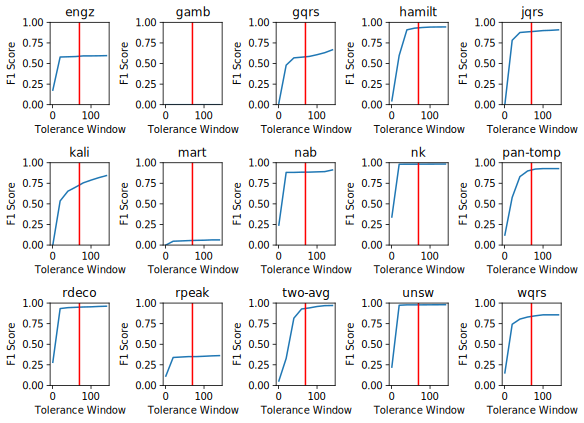

In [95]:
detectors = tol_data.detector.unique()
fig, axes = plt.subplots(3, 5, figsize=(8, 6))

for i, detector in enumerate(detectors):
    x = np.array(tol_data[tol_data.detector == detector].tolerance_window)
    y = np.array(tol_data[tol_data.detector == detector].f1_score)

    x_ax = int(i/(len(detectors)/3))
    y_ax = int(i%(len(detectors)/3))
    sns.lineplot(x=x, y=y, ax=axes[x_ax][y_ax])
    axes[x_ax][y_ax].axvline(x = 70, color = 'r')
    axes[x_ax][y_ax].set_title(detector)
    axes[x_ax][y_ax].set_ylim(0,1)
    axes[x_ax][y_ax].set_xlabel('Tolerance Window')
    axes[x_ax][y_ax].set_ylabel('F1 Score')


# Show the plot
plt.tight_layout()
filepath = 'data_autosave/tolerance_window_analysis_' + databases[0].Name + '.svg'
plt.savefig(filepath)

plt.show()


# Experiment - Synthetic Data

In [96]:
if use_SYNTH_database is False:
    print('\n~~~ ANALYSIS FINISHED ~~~\n')
    raise SystemExit('Stopping execution as synthetic data experiment not required')


~~~ ANALYSIS FINISHED ~~~



SystemExit: Stopping execution as synthetic data experiment not required

/Users/petercharlton/miniconda3/envs/ecgbeats/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Setup

### Signal generator

Synthetic signals are generated using the different parameters defined in the next cell. If `generate_database` is False the simulation is skipped.

In [ ]:
if generate_SYNTH_database:
    path = join(parent_directory,'Signal_generator')
    path = eng.genpath(path)
    eng.addpath(path)


    rrLength = [40]        # A desired ECG signal length (the number of RR intervals) 
    APBrate = [0]      # Rate of atrial premature beats (APB). A number between 0 and 0.5
    onlyRR = [0]          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

    medEpis = [15]        # Median duration of an atrial fibrillation (AF) episode
    stayInAF = 1-np.log(2)/medEpis   # Probability to stay in AF state
    AFburden = [0, 1]      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

    noiseType = [0, 1, 2, 3]       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                                # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                                # 4 - mixture of type 1, type 2 and type 3 noises
    noiseRMS = [0.0, 0.5]     # Noise level in milivolts 

    realRRon = [1]        # 1 - real RR series are used, 0 - synthetic
    realVAon = [1]       # 1 - real ventricular activity is used, 0 - synthetic
    realAAon = [1]        # 1 - real atrial activity is used, 0 - synthetic

    repeats = 200

    data = eng.Adapted_simPAF_ECG_generator_iterator(matlab.double(rrLength),matlab.double(APBrate),matlab.double(onlyRR),matlab.double(medEpis),matlab.double(stayInAF),matlab.double(AFburden),matlab.double(noiseType),matlab.double(noiseRMS),matlab.double(realRRon),matlab.double(realVAon),matlab.double(realAAon), matlab.double(repeats))

The cell calculates how many signals already existed before and saves this in `lastwritten`, to be able to add upon existing signals instead of creating the whole database from scratch every time.

In [ ]:
if generate_SYNTH_database:
    path = join(current_working_directory,'databases/SYNTH')
    files = [f for f in listdir(path) if isfile(join(path, f))]
    lastwritten = 0
    lastwritten = int(files[-1][3:6])
    print(lastwritten)

All signals are saved to the harddrive in the **wfdb format**. This format was choosen as it is common for databases and the resulting database can therefore be shared easily. All information created by the signal generator are saved as comments to make the database easily available. While only one lead is used for the experiments here, all of them are saved in the database.

In [ ]:
if generate_SYNTH_database:
    sig_name = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'X', 'Y', 'Z']
    path = join(current_working_directory,'databases/SYNTH')
    fs = 500

    for j in range(repeats):
        for i  in range(len(data)//repeats):
            synthetic_signal = data['s'+str(j+1)+'c'+str(i+1)]
            signal = np.transpose(np.array(synthetic_signal['multileadECG']))[0:segmentation_window_size*fs]
            actual_qrs_complexes = np.transpose(np.array(synthetic_signal['QRSindex'])).astype(int)
            actual_qrs_complexes = np.array([qrs for qrs in actual_qrs_complexes if qrs < (segmentation_window_size*fs-1)])
            
            rrLength = synthetic_signal['ip_rrLength']
            APBrate = synthetic_signal['ip_APBrate']
            stayInAF = synthetic_signal['ip_stayInAF']
            AFburden = synthetic_signal['ip_AFburden']
            noiseType = synthetic_signal['ip_noiseType']
            noiseRMS = synthetic_signal['ip_noiseRMS']
            realRRon = synthetic_signal['ip_realRRon']
            realVAon = synthetic_signal['ip_realVAon']
            realAAon = synthetic_signal['ip_realAAon']

            record_name = 'Rep'+str(format(j+lastwritten+1,'03d'))+'_AF' + str(int(AFburden)) + '_nT' + str(int(noiseType)) + '_nR' + str(format(noiseRMS, '.2f'))
            record_name = record_name.replace('.','-')
            record_comments = ['initial_rrLength='+str(rrLength),'APBrate='+str(APBrate),'stayInAF='+str(stayInAF),'AFburden='+str(AFburden),'noiseType='+str(noiseType),'noiseRMS='+str(noiseRMS),'realRRon='+str(realRRon),'realVAon='+str(realVAon),'realAAon='+str(realAAon),'repetition='+str(j+lastwritten+1),'element='+str(i+1),'signal_length(s)='+str(len(signal)//fs)]
            wfdb.wrsamp(record_name=record_name, fs = fs, units=['mV' for k in range(len(signal[0,:]))], sig_name=sig_name, p_signal=signal, write_dir=path,comments=record_comments)
            wfdb.wrann(record_name=record_name, fs= fs, extension='atr', sample=actual_qrs_complexes[:,0], symbol=['N' for l in range(len(actual_qrs_complexes))], write_dir=path)

### Evaluate database

Reads the database from wfdb format and saves it in an object. The difference to the pickled version below is that this one does not include the evaluations done below but only the initial signals ready for analysis.

In [ ]:
if evaluate_SYNTH_database:
    path = join(current_working_directory, 'databases/SYNTH')
    files = np.array([f[:-4] for f in listdir(path) if isfile(join(path, f)) and join(path, f).endswith('.dat')])

    fs = wfdb.rdrecord(join(path,str(files[0])), channels=[0]).fs

    repeats = int(files[-1][3:6])
    options = len(files)//repeats

    users = []

    for option in range(options):
        iterfiles = files[option::options]

        recordings = []
        for file in iterfiles:
            
            recordingsegments = []
            signal = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).p_signal[:,0]).astype(float)
            actual_qrs_complexes = np.array(wfdb.rdann(join(path,str(file)),'atr').sample[1:]).astype(int)

            comments = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).comments)
            additionalinfo = {
                'APBrate': float(comments[1][-3:]),
                'stayInAF': float(comments[2].split('=')[1]),
                'AFburden': float(comments[3].split('=')[1]),
                'noiseType': float(comments[4].split('=')[1]),
                'noiseRMS': float(comments[5].split('=')[1]),
                'realRRon': float(comments[6].split('=')[1]),
                'realVAon': float(comments[7].split('=')[1]),
                'realAAon': float(comments[8].split('=')[1]),
                'repetition': int(comments[9].split('=')[1]),
                'element': int(comments[10].split('=')[1]),
                'signal_length': int(comments[11].split('=')[1]),
            }

            recordings.append(Recording(RecordingName=str(file),RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, AdditionalInfo=additionalinfo))
        indexes = [3, 4, 5] 
        new_character = 'x'
        for i in indexes:
            name = iterfiles[0][:i] + new_character + iterfiles[0][i+1:]
        users.append(User(UserName=name,Recordings = recordings))

    synth_whole_database = Database(
        Name="Whole Synthetic Database",
        Users=users,
        Fs=fs)

The database is evaluated. All algorithms are run for every signal and for each of them different metrics are created. This step takes quite long. It can be skipped by loading a previus version of the evaluated database below.

In [ ]:
if evaluate_SYNTH_database:
    print('Database: ',synth_whole_database.Name)
    users = synth_whole_database.Users
    for j in range(len(users)):
        print('User: ',users[j].UserName)
        for recording in users[j].Recordings:
            recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

Pickles the evaluated database for easy use afterwards.

In [ ]:
if evaluate_SYNTH_database:
    filename = 'pickle/synth_whole_database_evaluated.pkl'
    file = open(filename, 'wb')
    pickle.dump(synth_whole_database, file)
    file.close()

### Load database

Reads a previously evaluated version of the synthetic database to perform analysis on it afterwards.

In [ ]:
if not evaluate_SYNTH_database:
    filename = 'pickle/synth_whole_database_evaluated.pkl'
    file = open(filename, 'rb')
    synth_whole_database = pickle.load(file)
    file.close()

In [ ]:
beats = 0
records = 0
for user in synth_whole_database.Users:
    for recording in user.Recordings:
        beats = beats + len(recording.WholeActual_Qrs_Complex)
        records = records + 1
print(synth_whole_database.Name,' has ', beats, ' beats, ', len(synth_whole_database.Users), ' users, and ', records, ' records')

### Create dataframe

This function defines how the signal to noise ratio is calculated using scipy. The mean is devided by the standard deviation, and then it is tranferred to a logarithmic scale.

In [ ]:
def signaltonoiseScipy(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(np.abs(np.where(sd == 0, 0, m/sd)))

The dataframe used in the evaluation of the synthetic data is created using the data claculated and read in a previous step. Some of the values are also converted to number formats.

In [ ]:
fs = synth_whole_database.Users[0].Recordings[0].Fs
users_all = synth_whole_database.Users

users = []
user_names = []
for user in users_all:
    record_name = user.UserName.replace('-','.')
    noiseRMS = float(record_name[-4:])
    noiseType = int(record_name[-8])
    if (not noiseRMS and noiseType) or (noiseRMS and not noiseType):
        continue
    users.append(user)
    user_names.append(user.UserName)

data_f1_score = []
data_sens = []
data_pospred = []
data_detector = []
data_user = []
data_af = []
data_noiseType = []
data_failed = []
data_runtime = []
data_snr_ms = []
data_snr_dB = []
data_impl = []
data_noise_no = []
data_noise_motion = []
data_noise_electrode = []
data_noise_baseline = []

for j in range(len(users)):
    for recording in users[j].Recordings:
        evaluations = recording.Evaluations
        for i in range(len(evaluations)):
            data_f1_score.append(evaluations[i].f1_score)
            data_sens.append(evaluations[i].sensitivity)
            data_pospred.append(evaluations[i].positive_predictivity)
            data_detector.append(detector_rename[evaluations[i].Detector.short_name])
            data_user.append(users[j].UserName)
            if int(users[j].UserName[9]):
                data_af.append('af')
            else:
                data_af.append('sr')
            data_noiseType.append(['no noise','motion artefacts','electrode movement','baseline wander'][int(users[j].UserName[13])])
            data_failed.append(evaluations[i].failed)
            data_runtime.append(evaluations[i].runtime*1000)
            data_snr_ms.append(signaltonoiseScipy(recording.WholeSignal))
            data_snr_dB.append(20*np.log10((np.max(recording.WholeSignal)-np.min(recording.WholeSignal))/(2*recording.AdditionalInfo["noiseRMS"] if recording.AdditionalInfo["noiseRMS"] != 0 else 0.001)))
            data_impl.append(detector_implementation[detector_rename[evaluations[i].Detector.short_name]])
            if data_noiseType[-1] == 'no noise':
                data_noise_no.append(1)
                data_noise_motion.append(0)
                data_noise_electrode.append(0)
                data_noise_baseline.append(0)
            elif data_noiseType[-1] == 'motion artefacts':
                data_noise_no.append(0)
                data_noise_motion.append(1)
                data_noise_electrode.append(0)
                data_noise_baseline.append(0)
            elif data_noiseType[-1] == 'electrode movement':
                data_noise_no.append(0)
                data_noise_motion.append(0)
                data_noise_electrode.append(1)
                data_noise_baseline.append(0)
            elif data_noiseType[-1] == 'baseline wander':
                data_noise_no.append(0)
                data_noise_motion.append(0)
                data_noise_electrode.append(0)
                data_noise_baseline.append(1)

data_synth = pandas.DataFrame(data=np.transpose(np.array([data_user,data_detector,data_f1_score,data_sens,data_pospred,data_af,data_noiseType,data_failed,data_runtime,data_snr_ms,data_snr_dB,data_impl, data_noise_motion, data_noise_electrode, data_noise_baseline,data_noise_no])),columns=['user','detector','f1_score','sensitivity','pos pred','af_sr','noiseType','failed','runtime','SNR MS','SNR dB','implementation','motion artefacts','electrode movement','baseline wander','no noise'])
data_synth['f1_score'] = data_synth['f1_score'].astype(float)
data_synth['sensitivity'] = data_synth['sensitivity'].astype(float)
data_synth['pos pred'] = data_synth['pos pred'].astype(float)
data_synth['runtime'] = data_synth['runtime'].astype(float)
data_synth['SNR MS'] = data_synth['SNR MS'].astype(float)
data_synth['SNR dB'] = data_synth['SNR dB'].astype(float)
data_synth['no noise'] = data_synth['no noise'].astype(float)
data_synth['motion artefacts'] = data_synth['motion artefacts'].astype(float)
data_synth['electrode movement'] = data_synth['electrode movement'].astype(float)
data_synth['baseline wander'] = data_synth['baseline wander'].astype(float)
data_synth['failed'] = data_synth['failed'].map({'True':True,'False':False})
data_synth.sort_values(by='detector',inplace=True)

## Results

#### Signal comparison

In [ ]:
showed_time = 15 # in seconds
users = []
user_names = []
for user in users_all:
    record_name = user.UserName.replace('-','.')
    noiseRMS = float(record_name[-4:])
    noiseType = int(record_name[-8])
    if (not noiseRMS and noiseType) or (noiseRMS and not noiseType):
        continue
    users.append(user)
    user_names.append(user.UserName)

shown_titles = ['\\acrshort{sr}, no noise','\\acrshort{sr}, motion artefacts', '\\acrshort{sr}, electrode movement','\\acrshort{sr}, baseline wander',
                '\\acrshort{af}, no noise','\\acrshort{af}, motion artefacts', '\\acrshort{af}, electrode movement','\\acrshort{af}, baseline wander']

names = []
fig, ax = plt.subplots(nrows=len(users)//2, ncols=2, sharex=True, figsize=(16, 8))
for j in range(len(users)):
    cnt = 0
    for recording in users[j].Recordings:
        if users[j].UserName not in names and cnt == 2:
            names.append(users[j].UserName)
            col = 0
            row = j
            if j > 3:
                col = 1
                row = row - 4
            signal = recording.WholeSignal[0:recording.Fs*showed_time]
            ax[row,col].vlines(x = recording.WholeActual_Qrs_Complex/recording.Fs, ymax=1, ymin = 0, transform=ax[row,col].get_xaxis_transform(), color=cmap[1],ls=':', lw=linewidth)
            ax[row,col].plot((np.array(range(len(signal))))/recording.Fs,signal,color=cmap[0])
            ax[row,col].set_xlim(0,showed_time)
            ax[row,col].set_title(shown_titles[j])
            if row == 3:
                ax[row,col].set_xlabel('Time (s)')
            ax[row,col].set_ylabel('\\acrshort{ecg} signal (au)')
            ax[row,col].tick_params(left = False, right = False , labelleft = False)
        else:
            cnt = cnt + 1
        
plt.tight_layout()
plt.savefig('data_autosave/synth_signals.svg')


NameError: name 'users_all' is not defined

#### General F1 results

This graph shows a boxplot of the general F1-results split up by algorithm.

In [ ]:
data_plot = data_synth
x = 'detector'
y = 'f1_score'

fig, ax = plt.subplots()
sns.boxplot(x='detector', y='f1_score', data=data_synth,ax=ax,saturation=saturation,linewidth=linewidth,flierprops=flierprops, color=cmap[0],showfliers=False)
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(bottom=0, top=1)
plt.tight_layout()
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
ax.set_ylabel('\\acrshort{f1} results')
ax.set_xlabel('Algorithms')
plt.tight_layout()
plt.savefig('data_autosave/synth_general.svg')
data_plot.groupby([x]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_general.xlsx', engine='openpyxl')
pass

This table shows the median sensitivity, positive predictivity, F1-scores, and runtime of the tests with synthetic data.

In [ ]:
data_synth.groupby(['detector']).median()

#### Comparing Atrial Fibrillation and Sinus Rhythm

This graph shows a comparison of the performance of algorithms on signals with sinus rhythm and signals with atrial fibrillation. Tests for statistical significant differences were also performed using the Mann-Whitney U test. For each algorithm and each type of signal boxplots are created.

In [ ]:
box_pairs = []
for detector in data_synth['detector'].unique():
    box_pairs.append(((detector, 'sr'), (detector, 'af')))
x = 'detector'
y = 'f1_score'
hue = 'af_sr'
hue_order = ['sr','af']
data_plot = data_synth[data_synth['noiseType'] == 'no noise']
# data_plot = data_synth

fig, ax = plt.subplots()
ax = sns.boxplot(ax=ax,x=x, y=y, hue=hue,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False,hue_order=hue_order)
ax.tick_params(axis='x', rotation=90)
test = add_stat_annotation(ax, data=data_synth, x=x, y=y, hue=hue, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction=None,hue_order=hue_order)

plt.tight_layout()
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
ax.set_ylabel('\\acrshort{f1} results')
ax.set_xlabel('Algorithms')
legend_elements = [matplotlib.patches.Patch(facecolor=cmap[0], edgecolor='k', linewidth=linewidth,
                         label='\\acrshort{sr}'),
                   matplotlib.patches.Patch(facecolor=cmap[1], edgecolor='k', linewidth=linewidth,
                         label='\\acrshort{af}')]
ax.legend(title='Arrhythmia Type', loc='lower right', handles=legend_elements,frameon=False)
plt.savefig('data_autosave/synth_af_sr.svg')
data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_af_sr.xlsx', engine='openpyxl')
pass

#### Noise Type Comparison

This graph compares differnt noise types across the algorithms. For each a boxplot is created, omitting the outliers. Additionally Mann-Whitney U tests for statistically significant differences were performed as shown in the graph.

In [ ]:
data_plot = data_synth
#data_plot = data_synth[data_synth['detector'].isin(['gqrs', 'jqrs', 'mart', 'nk', 'unsw'])]
box_pairs = []
detectors = data_plot['detector'].unique()
noiseTypes = data_plot['noiseType'].unique()
# for detector in detectors:
#     for i in range(len(noiseTypes)):
#         for j in range(len(noiseTypes)):
#             if (j <= i):
#                 continue
#             box_pairs.append(((detector, noiseTypes[i]), (detector, noiseTypes[j])))
for detector in detectors:
    for noiseType in noiseTypes:
            if noiseType == 'no noise':
                continue
            box_pairs.append(((detector, 'no noise'), (detector, noiseType)))
x = 'detector'
y = 'f1_score'
hue = 'noiseType'
hue_order = ['no noise','baseline wander','electrode movement','motion artefacts',]

fig, ax = plt.subplots(figsize=(7, 7))#figsize=(12, 8))
sns.boxplot(x=x, y=y, hue=hue,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
ax.tick_params(axis='x', rotation=90)
test = add_stat_annotation(ax, data=data_plot, x=x, y=y, hue=hue,hue_order=hue_order, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction=None,)
plt.tight_layout()
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
ax.set_ylabel('\\acrshort{f1} results')
ax.set_xlabel('Algorithms')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),frameon=False,title='Noise Type')
plt.savefig('data_autosave/synth_noise.svg')
data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_noise.xlsx', engine='openpyxl')
pass

In [ ]:
box_pairs = []
detectors = data_synth['detector'].unique()
noiseTypes = data_synth['noiseType'].unique()

for detector in detectors:
    box_pairs.append(((detector, 'baseline wander'), (detector, 'electrode movement')))
    box_pairs.append(((detector, 'electrode movement'), (detector, 'motion artefacts')))
    box_pairs.append(((detector, 'baseline wander'), (detector, 'motion artefacts')))
x = 'detector'
y = 'f1_score'
hue = 'noiseType'
hue_order = ['no noise','baseline wander','electrode movement','motion artefacts',]
order = detectors
data_plot = data_synth

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x=x, y=y, hue=hue,order=order,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
ax.tick_params(axis='x', rotation=90)
test = add_stat_annotation(ax, data=data_plot, x=x, y=y, order=order, hue=hue,hue_order=hue_order, box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction=None,)
plt.tight_layout()
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
ax.set_ylabel('\\acrshort{f1} results')
ax.set_xlabel('Algorithms')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),frameon=False,title='Noise Type')
plt.savefig('data_autosave/synth_noise_additional_tests.svg')
data_plot.groupby([x, hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_noise_additional_tests.xlsx', engine='openpyxl')
pass

#### Correlation Investigation

This heatmap shows the Kendall correlation coefficients between the different parameters. All parameters that were not available in number format were converted to numbers using the cat codes provided by `pandas`. To check for significant correlations, the p-values of the Kendall correlation were used. Only significant values are shown in the heatmap.

In [ ]:
def corr_sig_ken(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.kendalltau(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

In [ ]:
data_as_number = data_synth.copy(deep=True)
for t in ['user','detector','af_sr','noiseType']:
    data_as_number[t] = data_synth[t].astype('category').cat.codes
data_as_number = data_as_number[['user','detector','f1_score', 'af_sr','no noise', 'motion artefacts','electrode movement','baseline wander']]
cmap_cont = matplotlib.colors.LinearSegmentedColormap.from_list('custom colors', [cmap[0],cmap[1]], N=256)

corr = data_as_number.corr(method='kendall')
p_values = corr_sig_ken(data_as_number)
mask = np.invert(np.triu(p_values<0.05))
fig, ax = plt.subplots()
sns.heatmap(corr, mask=mask,
           xticklabels=corr.columns.values, 
           yticklabels=corr.columns.values, 
           cmap=cmap_cont,
            annot=True)
plt.tight_layout()

#### Signal to Noise Ratio Investigation

The fixed signal to noise ratios are investigated for each type of generated signal.

In this graph the signal to noise Ratio is calculated by subtracting the minimum of a signal from the maximum of that signal and dividing it by two times the added noise level.

In [ ]:
data_plot = data_synth
x = 'user'
y = 'SNR dB'
order = np.sort(data_plot['user'].unique())
fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data_plot,order=order,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False,color=cmap[0])
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.savefig('data_autosave/synth_snr_dB.svg')
data_plot.groupby([x]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_snr_dB.xlsx', engine='openpyxl')
pass

This graphs shows the signal to noise ratio calculated by dividing the mean of the signal by the signals standard deviation.

In [ ]:
data_plot = data_synth
x = 'user'
y = 'SNR MS'
order = np.sort(data_plot['user'].unique())
fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data_synth,order=order,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False,color=cmap[0])
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.savefig('data_autosave/synth_snr_ms.svg')
data_plot.groupby([x]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_snr_ms.xlsx', engine='openpyxl')
pass

#### Runtime Investigation

The runtime per algorithm is investigated with the bar height showing the median. Errorbars showing the 1st and 3rd quartile are also displayed for each runtime. The runtime is given in seconds. The different colors show, whether a specific algorithm was implemented in Pyhton or in MATLAB.

In [ ]:
fontsize = 4
data_plot = data_synth
x = 'detector'
y = 'runtime'

# hue = 'user'

# hue_order = ['Rep00x_AF0_nT0_nR0-00', 'Rep00x_AF0_nT3_nR0-50', 'Rep00x_AF0_nT2_nR0-50','Rep00x_AF0_nT1_nR0-50',  
#             'Rep00x_AF1_nT0_nR0-00', 'Rep00x_AF1_nT3_nR0-50', 'Rep00x_AF1_nT2_nR0-50', 'Rep00x_AF1_nT1_nR0-50']
names = []
for hue_it in hue_order:
    name = ''
    if 'AF1' in hue_it:
        name = name + 'AF, '
    else:
        name = name + 'nonAF, '
    if 'nT0' in hue_it:
        name = name + 'no noise'
    elif 'nT1' in hue_it:
        name = name + 'motion artefacts'
    elif 'nT2' in hue_it:
        name = name + 'electrode movement'
    else:
        name = name + 'baseline wander'
    names.append(name)

detectors = np.sort(data_plot['detector'].unique())
cmap_plot = []
for detector in detectors:
    if detector_implementation[detector] == 'Python':
        cmap_plot.append(cmap[0])
    elif detector_implementation[detector] == 'MATLAB':
        cmap_plot.append(cmap[1])
cmap_plot = np.array(cmap_plot)

fig, ax = plt.subplots()# figsize=(10, 7.5))
sns.barplot(data=data_plot, x=x, y=y,ax=ax,linewidth=linewidth, edgecolor=linecolor, estimator=estimator,palette=cmap_plot,saturation=saturation, errorbar=None)#, errorbar=errorbar, errwidth=linewidth,capsize=capsize, errcolor=linecolor) ,  hue=hue,hue_order=hue_order
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
ax.set_ylabel('Runtime (ms)')
ax.set_xlabel('Algorithms')
#ax.set_yscale('log')

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.1f', label_type='edge') #, rotation=90, padding=4, fontsize=fontsize)
#ax.set_ylim(top=400)

legend_elements = [matplotlib.patches.Patch(facecolor=cmap[0], edgecolor='k', linewidth=linewidth,
                         label='\\gls{python}'),
                   matplotlib.patches.Patch(facecolor=cmap[1], edgecolor='k', linewidth=linewidth,
                         label='\\gls{matlab}')]
ax.legend(handles=legend_elements, loc='upper center',frameon=False, title='Implementation')
legend_elements = [matplotlib.patches.Patch(facecolor=cmap[i], edgecolor='k', linewidth=linewidth, label=names[i]) for i in range(len(names))]
#ax.legend(title='Signal Type', loc='upper center', handles=legend_elements,frameon=False)
plt.savefig('data_autosave/synth_runtime.svg')
data_plot.groupby([x]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_runtime.xlsx', engine='openpyxl')
pass

#### Error Investigation

It is investigated which algorithms ran into errors while evaluating specific samples. The results are shown in % errorate per signal type.

In [ ]:
data_plot = data_synth
x = 'detector'
y = 'failed'
hue = 'user'

hue_order = ['Rep00x_AF0_nT0_nR0-00', 'Rep00x_AF0_nT3_nR0-50', 'Rep00x_AF0_nT2_nR0-50','Rep00x_AF0_nT1_nR0-50',  
            'Rep00x_AF1_nT0_nR0-00', 'Rep00x_AF1_nT3_nR0-50', 'Rep00x_AF1_nT2_nR0-50', 'Rep00x_AF1_nT1_nR0-50']
names = []
for hue_it in hue_order:
    name = ''
    if 'AF1' in hue_it:
        name = name + 'AF, '
    else:
        name = name + 'nonAF, '
    if 'nT0' in hue_it:
        name = name + 'no noise'
    elif 'nT1' in hue_it:
        name = name + 'motion artefacts'
    elif 'nT2' in hue_it:
        name = name + 'electrode movement'
    else:
        name = name + 'baseline wander'
    names.append(name)

fig, ax = plt.subplots()

sns.barplot(x=x, y=y, hue=hue,hue_order=hue_order,errorbar=None,palette=cmap, data=data_plot,ax=ax,saturation=saturation, linewidth=linewidth, edgecolor=linecolor)
ax.tick_params(axis='x', rotation=90)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=1))
plt.tight_layout()
ax.set_ylabel('Errorrate')
ax.set_xlabel('Algorithms')
#sns.move_legend(ax, loc='upper center', frameon=False, title='Signal Type')

legend_elements = [matplotlib.patches.Patch(facecolor=cmap[i], edgecolor='k', linewidth=linewidth, label=names[i]) for i in range(len(names))]
ax.legend(title='Signal Type', loc='upper center', handles=legend_elements,frameon=False)
data_plot.groupby([x,hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_error.xlsx', engine='openpyxl')
plt.savefig('data_autosave/synth_error.svg')
pass

In [ ]:
data_plot = data_synth
x = 'detector'
y = 'f1_score'
hue = 'user'
order = detectors
data_plot = data_synth

hue_order = ['Rep00x_AF0_nT0_nR0-00', 'Rep00x_AF0_nT3_nR0-50', 'Rep00x_AF0_nT2_nR0-50','Rep00x_AF0_nT1_nR0-50',  
            'Rep00x_AF1_nT0_nR0-00', 'Rep00x_AF1_nT3_nR0-50', 'Rep00x_AF1_nT2_nR0-50', 'Rep00x_AF1_nT1_nR0-50']
names = []
for hue_it in hue_order:
    name = ''
    if 'AF1' in hue_it:
        name = name + 'AF, '
    else:
        name = name + 'nonAF, '
    if 'nT0' in hue_it:
        name = name + 'no noise'
    elif 'nT1' in hue_it:
        name = name + 'motion artefacts'
    elif 'nT2' in hue_it:
        name = name + 'electrode movement'
    else:
        name = name + 'baseline wander'
    names.append(name)


fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x=x, y=y, hue=hue,order=order,hue_order=hue_order,data=data_plot,palette=cmap,saturation=saturation,linewidth=linewidth,flierprops=flierprops,showfliers=False)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
ax.set_ylabel('\\acrshort{f1} results')
ax.set_xlabel('Algorithms')

legend_elements = [matplotlib.patches.Patch(facecolor=cmap[i], edgecolor='k', linewidth=linewidth, label=names[i]) for i in range(len(names))]
ax.legend(title='Signal Type', loc="upper left", bbox_to_anchor=(1, 1),handles=legend_elements,frameon=False)
#data_plot.groupby([x,hue]).quantile(q=[0,.05,.25,.5,.75,.95,1]).to_excel('data_autosave/synth_error.xlsx', engine='openpyxl')
#plt.savefig('data_autosave/synth_error.svg')
pass

#### Algorithm Analyzer

In [ ]:
data_synth[data_synth['detector'] == 'nk'].groupby(['user']).median()

In [ ]:
fs = synth_whole_database.Users[0].Recordings[0].Fs
users_all = synth_whole_database.Users

users = []
user_names = []
for user in users_all:
    record_name = user.UserName.replace('-','.')
    noiseRMS = float(record_name[-4:])
    noiseType = int(record_name[-8])
    if (not noiseRMS and noiseType) or (noiseRMS and not noiseType):
        continue
    users.append(user)
    user_names.append(user.UserName)

#for user in users[0]:
    #for recording in user.Recordings[0]:
user = users[0]
recording = user.Recordings[0]
name = user.UserName
signal = recording.WholeSignal
fs = recording.Fs
actual_qrs_complexes = recording.WholeActual_Qrs_Complex
evaluations = recording.Evaluation([unsw_detector,neurokit_detector], predict_peaks, binary_classification, score_calculation)

markers = ["d", "v", "x", "+", "*", "^", "<", ">", "1", "2", "3", "4", "8", "s","p", "P", "h", "H", "X", "D", "|", "_", ".", "o"]
colors = ["r", "b", "c", "m", "y"]#, "k"]

fmt = [marker + color for marker in markers for color in colors]

#fmt = ['bo','r<','c^','m>','yv','rx','kd','cp','cx','b>','yx','mx','bx', 'rd', 'r0']
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(signal, color=cmap[0])
#ax.plot(actual_qrs_complexes, signal[actual_qrs_complexes], 'go', label = "Actual QRS Complexes")
for act in actual_qrs_complexes:
    ax.axvspan(act-150*fs/1000, act+150*fs/1000, alpha=0.25, color='gray')
ax.vlines(x = actual_qrs_complexes, ymax=0, ymin = 1, transform=ax.get_xaxis_transform(), color=cmap[1],ls=':', lw=linewidth)
for i in range(len(evaluations)):
    ax.plot(evaluations[i].predicted_peaks, signal[evaluations[i].predicted_peaks], fmt[i],label=detector_rename[evaluations[i].Detector.short_name])
#ax.set_title(name)
ax.set_xlim(1000,6000)
ax.set_xlabel("Time (au)")
ax.set_ylabel('ECG signal (au)')
ax.tick_params(left = False, right = False , bottom=False, labelleft = False, labelbottom=False)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1),frameon=False, title='Algorithm')
        #fig.legend()